# Homework 2 - Steam Reviews

### Libraries




In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt # to Converte the timestamp variables from int to seconds
import matplotlib.pyplot as plt # for plotting graphics
import seaborn as sns
import matplotlib.ticker as ticker
import altair as alt   # Altair interactive graphics
from scipy.stats import mannwhitneyu, spearmanr
import statsmodels.api as sm
from tqdm import tqdm

import functions as f

In [ ]:
# Install the kaggle API
%pip install kaggle

# Download the dataset from kaggle
%kaggle datasets download najzeko/steam-reviews-2021
%unzip steam-reviews-2021.zip

In [56]:
df = pd.read_csv('/steam_reviews.csv', header = 'infer')

In [ ]:
# Converte the timestamp variables from int to seconds
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit = 's')
df['timestamp_updated'] = pd.to_datetime(df['timestamp_updated'], unit = 's')
df['author.last_played'] = pd.to_datetime(df['author.last_played'], unit = 's')

## **RQ1** 
Before diving deep into the dataset provided, it's crucial to understand its structure and main features. So we perform an EDA and summarize the dataset's key characteristics using visualizations and tabular summaries.

### **EDA**

In [ ]:
# 1.1 removing Na Values and counting the Null values

print(df.isnull().sum())
df = df.dropna(inplace=True)

Unnamed: 0                            0
app_id                                0
app_name                              0
review_id                             0
language                              0
review                            33748
timestamp_created                     0
timestamp_updated                     0
recommended                           0
votes_helpful                         0
votes_funny                           0
weighted_vote_score                   0
comment_count                         0
steam_purchase                        0
received_for_free                     0
written_during_early_access           0
author.steamid                        0
author.num_games_owned                0
author.num_reviews                    0
author.playtime_forever               2
author.playtime_last_two_weeks        2
author.playtime_at_review         25682
author.last_played                    2
dtype: int64


In [ ]:
# Check it
# Outliers

df = df[
    (df['author.num_games_owned'] <= 50000) &
    (df['author.num_reviews'] <= 50000) &
    (df['votes_helpful']) <= 50000
]

mean_votes_funny = df.loc[df['votes_funny'] <= 50000, 'votes_funny'].mean()
df['votes_funny'] = df['votes_funny'].fillna(mean_votes_funny)
df.loc[df['votes_funny'] > 50000, 'votes_funny'] = mean_votes_funny

In [ ]:
# 1.1.1 Create subdf where duplicates are eliminated. It can be helpful for next exercises.

#df_no_duplicates = df.drop_duplicates(subset=['review', 'author.steamid'])
#df_no_duplicates.reset_index(drop=True, inplace=True)

In [62]:
# 1.2 Info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21687945 entries, 0 to 21747370
Data columns (total 23 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   Unnamed: 0                      int64         
 1   app_id                          int64         
 2   app_name                        object        
 3   review_id                       int64         
 4   language                        object        
 5   review                          object        
 6   timestamp_created               datetime64[ns]
 7   timestamp_updated               datetime64[ns]
 8   recommended                     bool          
 9   votes_helpful                   int64         
 10  votes_funny                     float64       
 11  weighted_vote_score             float64       
 12  comment_count                   int64         
 13  steam_purchase                  bool          
 14  received_for_free               bool          
 15  w

In [63]:
df.describe()

,Unnamed: 0,app_id,review_id,timestamp_created,timestamp_updated,votes_helpful,votes_funny,weighted_vote_score,comment_count,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
count,2.168794e+07,2.168794e+07,2.168794e+07,21687945,21687945,2.168794e+07,2.168794e+07,2.168794e+07,2.168794e+07,2.168794e+07,2.168794e+07,2.168794e+07,2.168794e+07,2.168794e+07,2.168794e+07,21687945
mean,1.087507e+07,3.929268e+05,5.188274e+07,2018-12-10 17:56:20.150121216,2019-01-15 22:56:17.220821760,4.055771e+05,8.148785e-01,1.655262e-01,1.309590e-01,7.656120e+16,1.014071e+06,4.055857e+05,1.611046e+04,1.555894e+02,8.809664e+03,2020-02-01 15:37:33.922483200
min,0.000000e+00,7.000000e+01,4.300000e+01,2010-11-19 20:17:16,2010-11-19 20:17:16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1970-01-01 00:00:00
25%,5.438943e+06,2.427600e+05,3.642574e+07,2017-11-10 19:23:34,2017-11-27 03:32:55,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,2.200000e+01,2.000000e+00,1.253000e+03,0.000000e+00,5.590000e+02,2019-11-10 08:14:24
50%,1.087574e+07,3.595500e+05,5.383820e+07,2019-07-06 20:28:58,2019-10-27 11:48:18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.656120e+16,6.100000e+01,4.000000e+00,4.315000e+03,0.000000e+00,1.881000e+03,2020-09-02 16:01:43
75%,1.631054e+07,5.780800e+05,6.928469e+07,2020-05-17 04:42:36,2020-06-05 21:29:39,1.000000e+00,0.000000e+00,4.829141e-01,0.000000e+00,7.656120e+16,1.460000e+02,1.000000e+01,1.493800e+04,0.000000e+00,6.825000e+03,2020-12-26 17:07:27
max,2.174738e+07,1.291340e+06,8.521867e+07,2021-01-23 18:24:47,2042-05-11 00:59:57,4.398047e+12,2.253200e+04,9.959868e-01,4.893000e+03,7.656120e+16,4.398047e+12,4.398047e+12,3.744943e+06,2.703900e+04,3.228103e+06,2021-01-23 20:35:42
std,6.277563e+06,2.481071e+05,2.083272e+07,NaN,NaN,1.335567e+09,2.791677e+01,2.434493e-01,2.201967e+00,3.179290e+08,2.111716e+09,1.335567e+09,3.745428e+04,7.301101e+02,2.389216e+04,NaN


In [64]:
df.head()

,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,2021-01-23 06:00:29,2021-01-23 06:00:29,True,0,...,True,False,False,76561199095369542,6,2,1909.0,1448.0,1909.0,2021-01-22 19:23:03
1,1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,2021-01-23 05:50:30,2021-01-23 05:50:30,True,0,...,True,False,False,76561198949504115,30,10,2764.0,2743.0,2674.0,2021-01-23 07:18:27
2,2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,2021-01-23 05:46:40,2021-01-23 05:46:40,True,0,...,True,False,False,76561199090098988,5,1,1061.0,1061.0,1060.0,2021-01-23 06:36:17
3,3,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",2021-01-23 05:32:50,2021-01-23 05:32:50,True,0,...,True,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,2021-01-23 06:35:44
4,4,292030,The Witcher 3: Wild Hunt,85184287,schinese,大作,2021-01-23 05:23:47,2021-01-23 05:23:47,True,0,...,True,False,False,76561199028326951,7,4,217.0,42.0,217.0,2021-01-16 09:10:49


#### Some Plots
We'll do two pie plots of: 
- steam purchase (True/False)
- received for free (True/False)

Our objective is to see if `"steam purchase" == False` corresponds to `"received for free" == True` or not

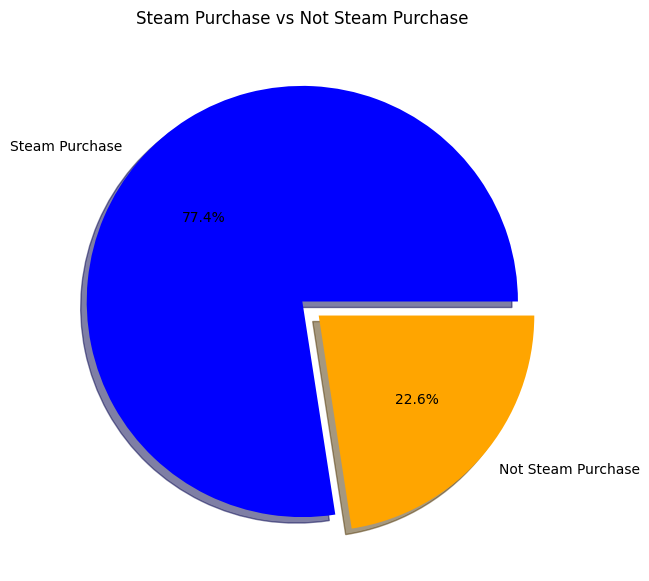

steam_purchase
True     16796125
False     4891820
Name: count, dtype: int64


In [ ]:
# Plot of steam purchase
explode = [0,0.1]
colors = "blue", "orange"
plt.figure(figsize = (7,7))
plt.pie(df['steam_purchase'].value_counts(), labels = ['Steam Purchase', 'Not Steam Purchase'], autopct = '%1.1f%%',
        colors = colors,
        explode = explode,
        shadow = True)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Steam Purchase vs Not Steam Purchase')
plt.show()

print(df['steam_purchase'].value_counts())

received_for_free
False    21001502
True       686443
Name: count, dtype: int64


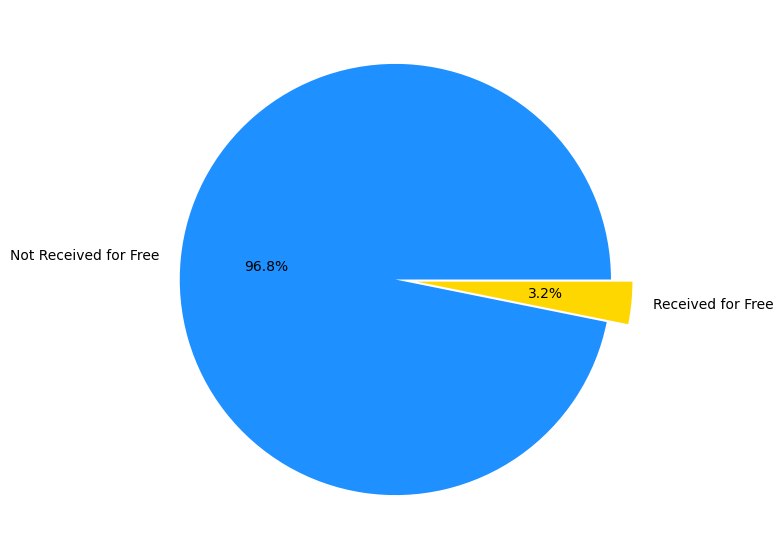

In [ ]:
# Plot of received for free
colors = "dodgerblue", "gold"
explode = [0,0.1]
plt.figure(figsize = (7,7))
plt.pie(df['received_for_free'].value_counts(), labels = ['Not Received for Free', 'Received for Free'], autopct = '%1.1f%%',
        colors = colors,
        explode = explode)

print(df['received_for_free'].value_counts())

Its pretty obvious from the result that if someone didn't purchase on steam the game, he won't necessary receive it for free. We will study this case better in the next RQ. 77.4% of the people purchased the game on steam while 22.6% of the people did not. At the same time, 96.8% did not received the game for free, while 3.2% did it. Therefore, there is a part of our population that got the apps in other ways; it could be that they bought it from other digital platforms or from a physical store (if that's possible). It would be interesting to understand why people should write a review on "steam" while they get the app elsewhere (even if they are a minority).


#### Pie Plot of Recommendations

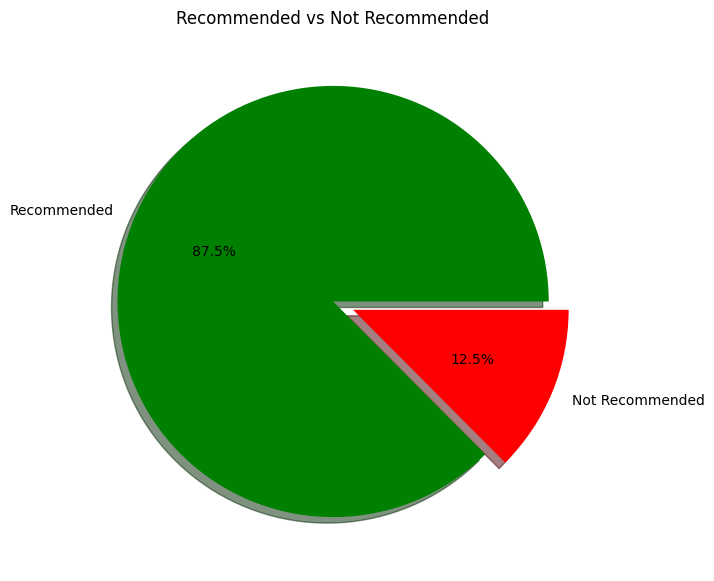

recommended
True     18968648
False     2719297
Name: count, dtype: int64


In [ ]:
# Pie Plot of Recommendations
plt.figure(figsize = (7,7))
colors = "green", "red"
explode = [0,0.1]
plt.pie(df['recommended'].value_counts(), labels = ['Recommended', 'Not Recommended'], autopct = '%1.1f%%',
        colors = colors,
        explode = explode,
        shadow = True)

plt.title('Recommended vs Not Recommended')
plt.show()

print(df['recommended'].value_counts())

From this pieplot we can see that:
- 87.5% of the reviews recommend the app/game
- 12.5% of the reviews do not recommend the app/game

Such a high recommendation value is an indicator of reliability, which can positively affect the growth of the user base, as new users will be more likely to try the game/app based on positive feedback. This could be part of an attractive loop in the digital platform.

Instead, a low percentage of users who do not recommend the app suggests that the problems encountered by these users are probably less common or concern specific aspects that have not affected the majority of the apps.

We should also consider that in digital platforms like "steam" there could be reviews influenced by aspects beyond the control of the app distributor (such as price changes), by personal taste or by strategic distortions such as fake reviews (which can negatively affect the number of recommendations in an application).

#### BarPlot of Reviews' languages

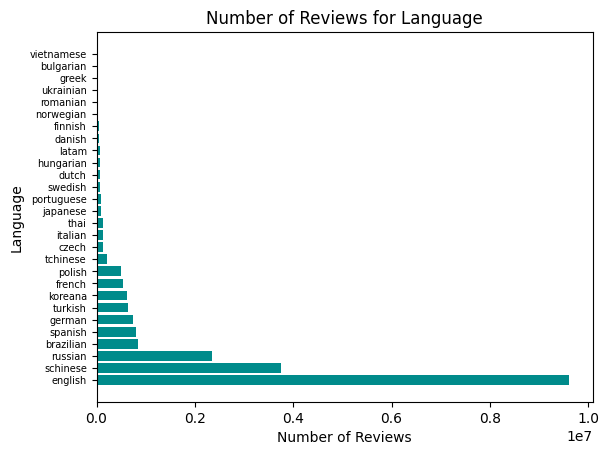

In [ ]:
# BarPlot of Reviews' languages
plt.barh(df['language'].value_counts().index, df['language'].value_counts().values, color = "darkcyan")
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 7)
plt.xlabel('Number of Reviews')
plt.ylabel('Language')
plt.title('Number of Reviews for Language')
plt.show()

From this analisys we can see that the most used languages for reviewing are:
1. english
2. simple chinese
3. russian (descending order for number of reviews)

At the same time, the least used languages are:
1. vietnamese
2. bulgarian
3. greek (ascending order for number of reviews)

#### Most played apps/games

                           app_name  author.playtime_forever
182   PLAYERUNKNOWN'S BATTLEGROUNDS             5.943908e+10
273  Tom Clancy's Rainbow Six Siege             2.577154e+10
208                            Rust             2.319573e+10
114                     Garry's Mod             2.222260e+10
118              Grand Theft Auto V             2.103350e+10
..                              ...                      ...
36                      Budget Cuts             7.234110e+05
198                 Rapture Rejects             5.384870e+05
223       Shadow Complex Remastered             4.639810e+05
82                      Down To One             4.253940e+05
164                  Neon Hardcorps             3.698300e+04

[315 rows x 2 columns]


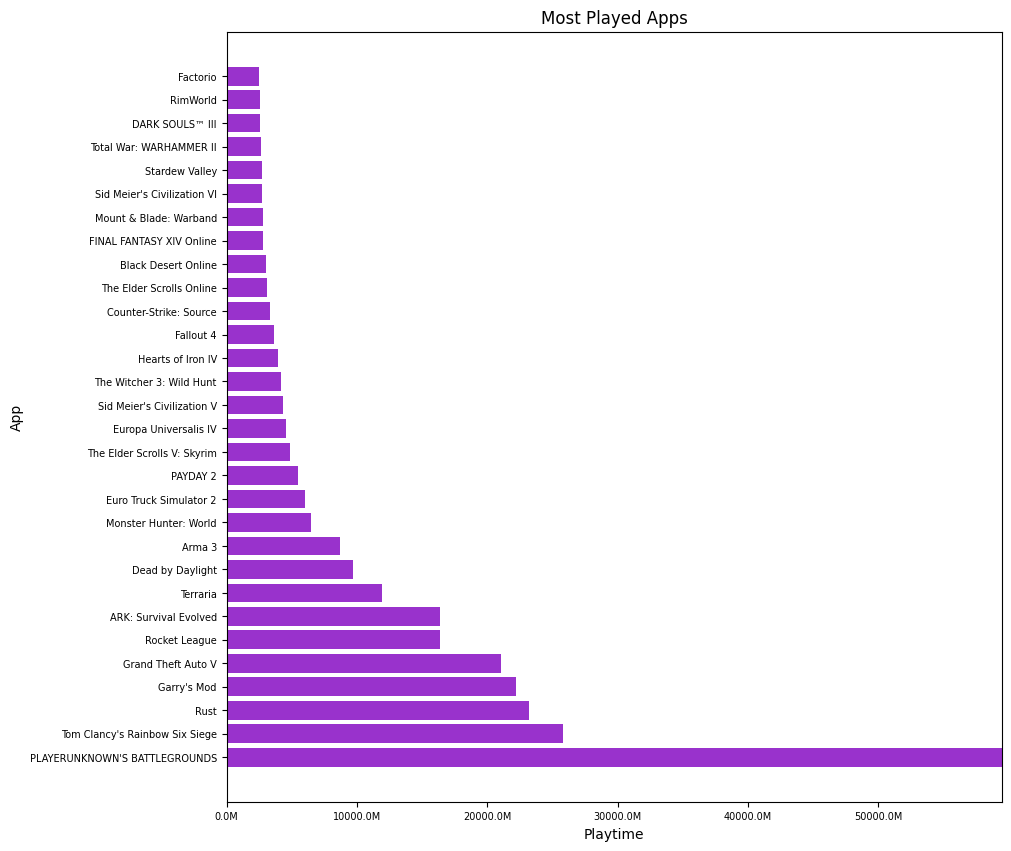

In [ ]:
# Most played apps/games
most_played_games = df.groupby('app_name')['author.playtime_forever'].sum().reset_index().sort_values('author.playtime_forever', ascending = False)
print(most_played_games)

plt.figure(figsize = (10, 10))
plt.barh(most_played_games['app_name'].head(30), most_played_games['author.playtime_forever'].head(30), color = "darkorchid")
plt.xticks(fontsize = 7)
plt.yticks(fontsize = 7)
plt.xlim(0, most_played_games['author.playtime_forever'].max() + 1000000)


######################################
# Define the millions function to change the xi's
def millions(x, pos):
    return f'{x * 1e-6:.1f}M'
######################################


plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.xlabel('Playtime')
plt.ylabel('App')
plt.title('Most Played Apps')
plt.show()

We can see the most and the least played games (using the variable "author.playtime_forever" --> in hours). 
They're printed in the output (see above).

#### Playtime after reviews

Now, we want to find the playtime after that the author reviewed the game, to see if they continued it or not, and if they did, how much time they spent on it.

In [ ]:
# Playtime after reviews

df['playtime_after_review'] = df['author.playtime_forever'] - df['author.playtime_at_review']
print(df[['author.steamid','author.playtime_forever','author.playtime_at_review','playtime_after_review']])

average_time_after_review = df['playtime_after_review'].mean()
print(f'Average time spent after the review: {average_time_after_review}')

             author.steamid  author.playtime_forever  \
0         76561199095369542                   1909.0   
1         76561198949504115                   2764.0   
2         76561199090098988                   1061.0   
3         76561199054755373                   5587.0   
4         76561199028326951                    217.0   
...                     ...                      ...   
21747366  76561197967033932                    432.0   
21747367  76561198046495482                   3296.0   
21747368  76561198176379749                   2654.0   
21747369  76561198041763187                    210.0   
21747370  76561198116747069                   1062.0   

          author.playtime_at_review  playtime_after_review  
0                            1909.0                    0.0  
1                            2674.0                   90.0  
2                            1060.0                    1.0  
3                            5524.0                   63.0  
4                     

We calculate the average playtime metrics (playtime forever = total playtime, playtime at review and playtime after review) and use a Barplot to see graphically the differences

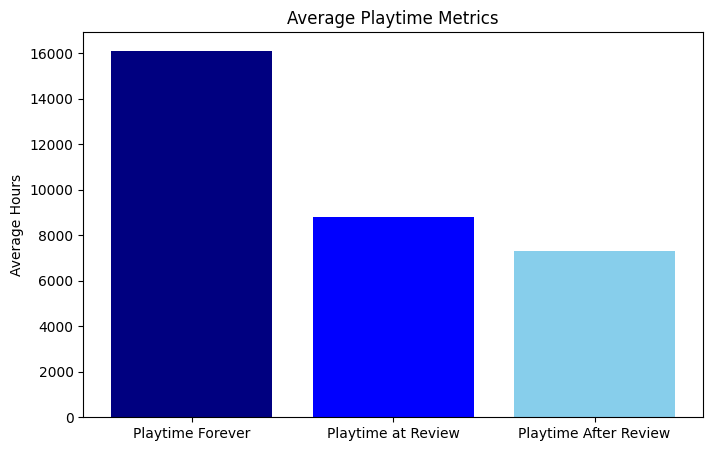

In [ ]:
mean_values = [
    df['author.playtime_forever'].mean(),
    df['author.playtime_at_review'].mean(),
    df['playtime_after_review'].mean()
]

labels = ['Playtime Forever', 'Playtime at Review', 'Playtime After Review']
plt.figure(figsize=(8, 5))
plt.bar(labels, mean_values, color=['navy', 'blue', 'skyblue'])
plt.ylabel('Average Hours')
plt.title('Average Playtime Metrics')
plt.show()

#### Heatmap



Now, we want to find the playtime after that the author reviewed the game, to see if they continued it or not, and if they did, how much time they spent on it.
Let's do an heatmap to see all the correlations between numerical variables in the dataset.

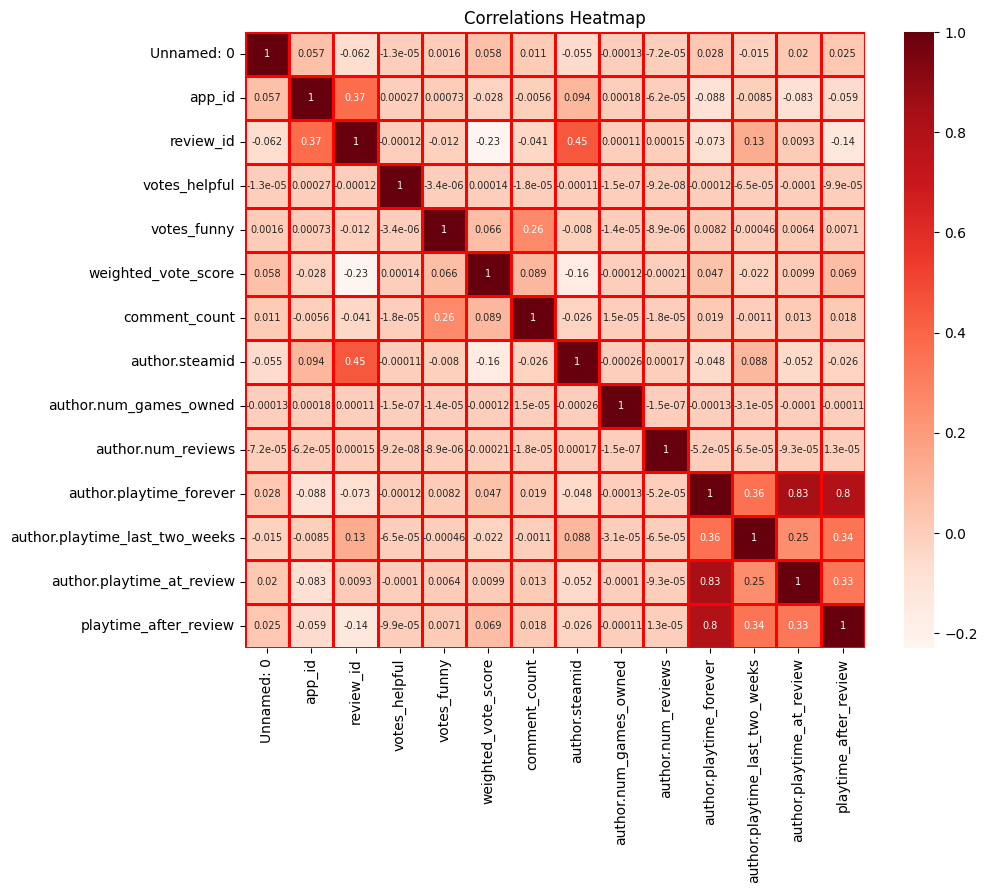

In [ ]:
# Heatmap to see correlations
df_numeric = df.select_dtypes(include=['float64', 'int64'])

correlation_matrix = df_numeric.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 7}, linewidths=1, linecolor='red', cmap="Reds")
plt.title('Correlations Heatmap')
plt.show()

There are some interesting correlations between playtime_at_review/playtime_after_review and author.playtime_forever confirming what we have seen in the analysis before with the Barplot (of the differences).

## **RQ2** 

Let's explore the dataset by analyzing the distribution of reviews across different applications.


### **Question 2.1** 
Identify which applications have the highest and lowest number of reviews.

In [ ]:
# Identify which applications have the highest and lowest number of reviews.
df.groupby('app_name')['review_id'].count().sort_values(ascending = False)

app_name
PLAYERUNKNOWN'S BATTLEGROUNDS      1642631
Grand Theft Auto V                 1016370
Tom Clancy's Rainbow Six Siege      839838
Terraria                            671425
Garry's Mod                         653815
                                    ...   
Don't Escape: 4 Days to Survive       1011
Shadow Complex Remastered              699
Out of the Park Baseball 19            699
DRAGON QUEST HEROES™ II                599
Neon Hardcorps                         197
Name: review_id, Length: 315, dtype: int64

We can see in the output above the apps with the highest and lowest number of reviews (the maximum number is 1642631 and the minimum is 197)

### **Question 2.2** 
Plot the number of reviews for each application in descending order. What insights can you draw from the plot?


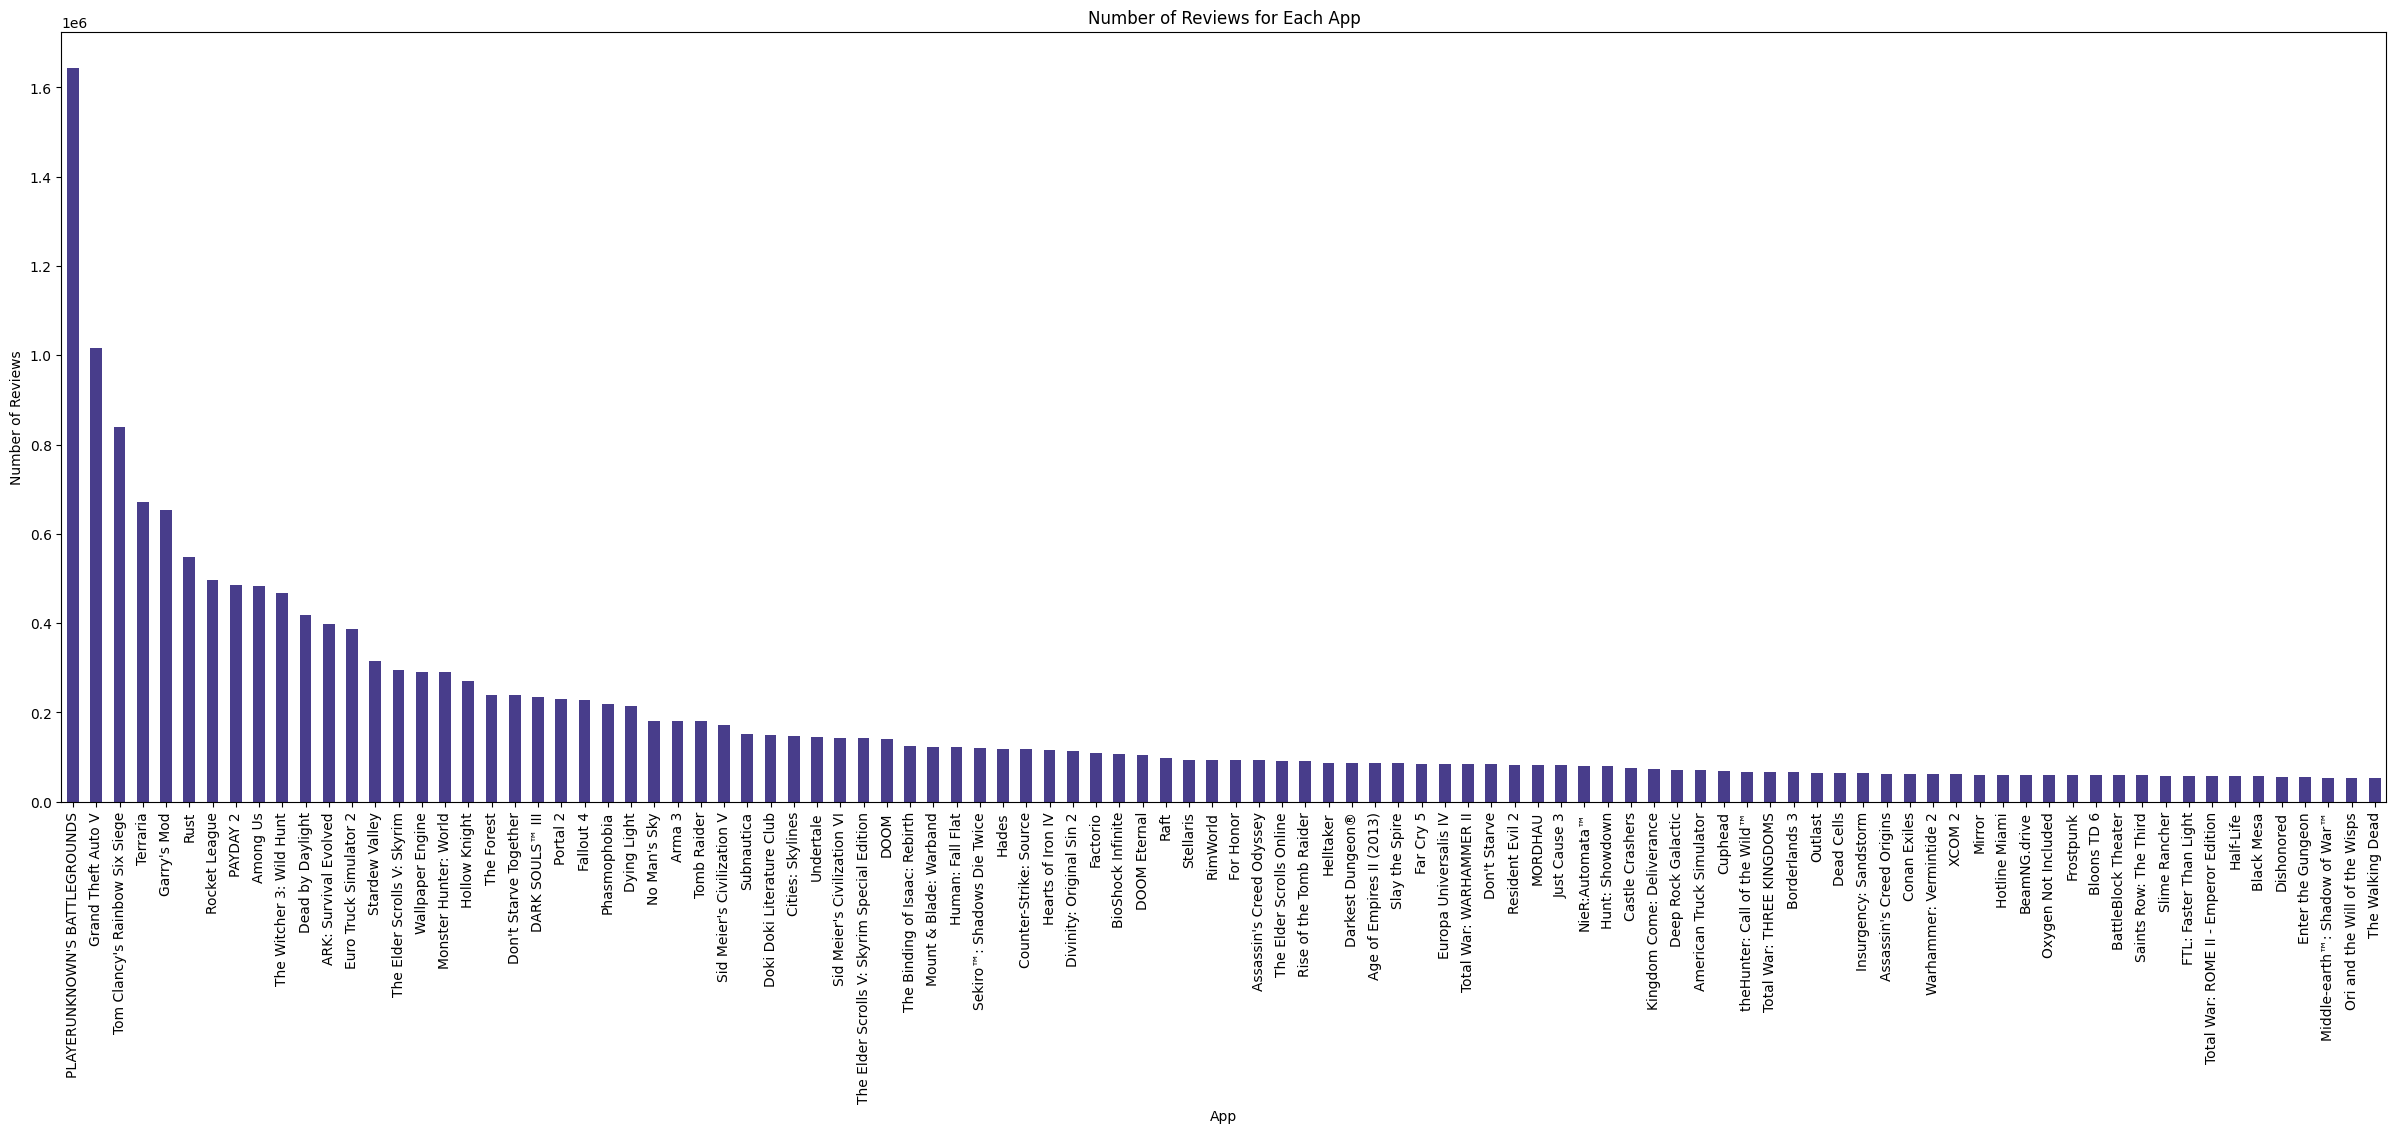

In [ ]:
# Plot the number of reviews for each application in descending order. What insights can you draw from the plot?
df.groupby('app_name')['review_id'].count().sort_values(ascending = False).head(100).plot(kind = 'bar', figsize = (30, 10), color = 'darkslateblue')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.title('Number of Reviews for Each App')
plt.xlabel('App')
plt.ylabel('Number of Reviews')
plt.show()

From the plot, we can see that the biggest part of reviews are concentrated in the first (about) 20 applications. It could be a synthom of their different popularity, and also of the number of players they have --> from an economic point of view, this can imply a not strong enough kind of marketing for the game or something similar. This is also called "long-tail" case, and it is common to most of the digital platforms (a reduced part of the elements receive the most part of the attention --> EX: products in Amazon.com)

Furthermore, we could have a kind of "Matthew Effect" where "Rich gets Richer" but in the sense that the more reviews an app have and the more it will have (and the contrary)

### **Question 2.3** 
For the top 5 applications by number of reviews, how many reviews came from users who purchased the application versus those who received it for free? Provide a percentage breakdown and highlight any similarities.

In [ ]:
# For the top 5 applications by number of reviews, how many reviews came from users who purchased the application
# versus those who received it for free? Provide a percentage breakdown and highlight any similarities

# Count the number of reviews for every game
app_review_counts = df['app_name'].value_counts()

# Top 5 Games
top_5_apps = app_review_counts.head(5).index.tolist()

print("Top 5 App for number of reviews:")
for app in top_5_apps:
    print(app)

for app in top_5_apps:
    app_df = df[df['app_name'] == app]
    total_reviews = len(app_df)

    # Number of reviews from who purchased the game on steam
    purchased_reviews = app_df[app_df['steam_purchase'] == True]
    num_purchased_reviews = len(purchased_reviews)
    perc_purchased_reviews = (num_purchased_reviews / total_reviews) * 100

    # Number of reviews from who received the game for free
    free_reviews = app_df[app_df['received_for_free'] == True]
    num_free_reviews = len(free_reviews)
    perc_free_reviews = (num_free_reviews / total_reviews) * 100

    # Print the results
    print(f"\nApp: {app}")
    print(f"Total number of reviews: {total_reviews}")
    print(f"Reviews from who purchased the app on steam: {num_purchased_reviews} ({perc_purchased_reviews:.2f}%)")
    print(f"Reviews from who received the app for free: {num_free_reviews} ({perc_free_reviews:.2f}%)")

Top 5 App for number of reviews:
PLAYERUNKNOWN'S BATTLEGROUNDS
Grand Theft Auto V
Tom Clancy's Rainbow Six Siege
Terraria
Garry's Mod

App: PLAYERUNKNOWN'S BATTLEGROUNDS
Total number of reviews: 1642631
Reviews from who purchased the app on steam: 1371356 (83.49%)
Reviews from who received the app for free: 61369 (3.74%)

App: Grand Theft Auto V
Total number of reviews: 1016370
Reviews from who purchased the app on steam: 902819 (88.83%)
Reviews from who received the app for free: 38542 (3.79%)

App: Tom Clancy's Rainbow Six Siege
Total number of reviews: 839838
Reviews from who purchased the app on steam: 700736 (83.44%)
Reviews from who received the app for free: 36233 (4.31%)

App: Terraria
Total number of reviews: 671425
Reviews from who purchased the app on steam: 526639 (78.44%)
Reviews from who received the app for free: 20130 (3.00%)

App: Garry's Mod
Total number of reviews: 653815
Reviews from who purchased the app on steam: 549792 (84.09%)
Reviews from who received the app f

The majority of the reviews for each top 5 applications (in terms of reviews) are written by people who purchased the app on steam.

There is a low percentage of reviews from users who have received the game for free.

The percentages are similar between different applications, suggesting common trends in user behavior and distribution strategies.

Reviews within a digital platform like "Steam" can generate attractive loops. Since a greater number of buyers on a platform makes the average rating of the product more informative, through reviews, a platform with such a system has positive network effects within the group among buyers.

So, users are inclined to prefer the purchase on the platform from which they obtain information.

This means: more buyers on the platform -> more reviews --> more buyers on the platform ---> etc.

In [ ]:
for app in top_5_apps:
    app_df = df[df['app_name'] == app]
    total_reviews = len(app_df)

    # Create a contingency table
    contingency_table = pd.crosstab(app_df['steam_purchase'], app_df['received_for_free'])

    contingency_table_perc = (contingency_table / total_reviews) * 100

    print(f"\nApp: {app}")
    print(f"Total Reviews number: {total_reviews}")
    print("Contingency Table:")
    print(contingency_table)
    print("Contingency Table (percent):")
    print(contingency_table_perc.round(2))


App: PLAYERUNKNOWN'S BATTLEGROUNDS
Total Reviews number: 1642631
Contingency Table:
received_for_free    False  True 
steam_purchase                   
False               253437  17838
True               1327825  43531
Contingency Table (percent):
received_for_free  False  True 
steam_purchase                 
False              15.43   1.09
True               80.84   2.65

App: Grand Theft Auto V
Total Reviews number: 1016370
Contingency Table:
received_for_free   False  True 
steam_purchase                  
False              106891   6660
True               870937  31882
Contingency Table (percent):
received_for_free  False  True 
steam_purchase                 
False              10.52   0.66
True               85.69   3.14

App: Tom Clancy's Rainbow Six Siege
Total Reviews number: 839838
Contingency Table:
received_for_free   False  True 
steam_purchase                  
False              125377  13725
True               678228  22508
Contingency Table (percent):
received_for_

In [77]:
for app in top_5_apps:
    app_df = df[df['app_name'] == app]
    total_reviews = len(app_df)

    app_df['Category'] = app_df.apply(lambda row:
                                       'Purchased (Steam)' if row['steam_purchase'] and not row['received_for_free'] else
                                       'Free' if not row['steam_purchase'] and row['received_for_free'] else
                                       'Other', axis=1)

    category_counts = app_df['Category'].value_counts().reset_index()
    category_counts.columns = ['Category', 'Count']
    category_counts['Percentage'] = (category_counts['Count'] / app_df.shape[0]) * 100

    chart = alt.Chart(category_counts).mark_bar().encode(
        x=alt.X('Category', sort=['Purchased (Steam)', 'Free']),
        y='Count',
        color=alt.Color('Category', scale=alt.Scale(scheme='set2')),
        tooltip=['Category', 'Count', alt.Tooltip('Percentage', format='.2f')]
    ).properties(
        title=f"Review distribution for '{app}'"
    ).interactive()

    chart.display()


/var/folders/jp/fnr369_172b9ghtllhyqdmtw0000gp/T/ipykernel_67974/3338599216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df['Category'] = app_df.apply(lambda row:


alt.Chart(...)

/var/folders/jp/fnr369_172b9ghtllhyqdmtw0000gp/T/ipykernel_67974/3338599216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df['Category'] = app_df.apply(lambda row:


alt.Chart(...)

/var/folders/jp/fnr369_172b9ghtllhyqdmtw0000gp/T/ipykernel_67974/3338599216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df['Category'] = app_df.apply(lambda row:


alt.Chart(...)

/var/folders/jp/fnr369_172b9ghtllhyqdmtw0000gp/T/ipykernel_67974/3338599216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df['Category'] = app_df.apply(lambda row:


alt.Chart(...)

/var/folders/jp/fnr369_172b9ghtllhyqdmtw0000gp/T/ipykernel_67974/3338599216.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_df['Category'] = app_df.apply(lambda row:


alt.Chart(...)

### **Question 2.4** 
Which applications have the most and the least user recommendations? Summarize your findings.

In [ ]:
# Which applications have the most and the least user recommendations? Summarize your findings.

df.groupby('app_name')['recommended'].mean().sort_values(ascending = False)

app_name
ULTRAKILL                        0.995337
Senren＊Banka                     0.994036
A Short Hike                     0.991446
The Henry Stickmin Collection    0.990223
Factorio                         0.989188
                                   ...   
NBA 2K18                         0.291809
Umbrella Corps                   0.281917
SOS                              0.278593
RollerCoaster Tycoon World       0.244747
Identity                         0.244296
Name: recommended, Length: 315, dtype: float64

The top 5 applications for number of reccommendations are: "ULTRAKILL", "Senren*Banka", "A Short Hike", "The Henry Stickmin Collection", "Factorio".

The least 5 applications for number of recommendations are: "NBA 2K18", "Umbrella Corps", "SOS", "RollerCoaster Tycoon World", "Identity".

With our analysis we can observe how applications that meet or exceed players' expectations get better ratings.

"ULTRAKILL" and "Factorio" are examples of applications (games) that have met or exceeded the expectations of users, unlike games like "Umbrella Corps" (from the brand "Resident Evil") or "NBA 2K18", both with high expectations but which have been found to be of low quality (or in any case with obvious problems).

Therefore, popularity can often lead to negative consequences, given by high expectations and greater attention to detail on the part of those who use the application.

/Users/roberto/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65290 (\N{FULLWIDTH ASTERISK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


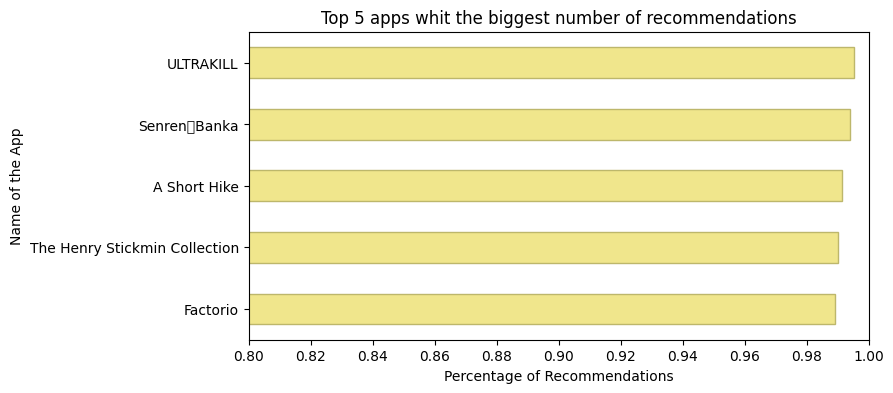

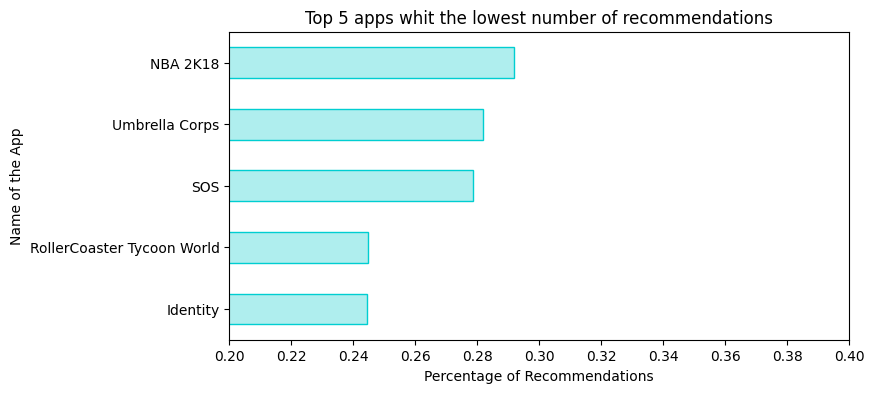

In [79]:
# Plots for 2.4
recommendation_rates = df.groupby('app_name')['recommended'].mean().sort_values(ascending = False)


top_5_apps = recommendation_rates.head(5)

bottom_5_apps = recommendation_rates.tail(5)


plt.figure(figsize=(8, 4))
top_5_apps.sort_values().plot(kind='barh', color='khaki', edgecolor = 'darkkhaki')

x_ticks = np.linspace(0.8, 1.0, num=11)


plt.xlim([0.8, 1.0])
plt.xticks(x_ticks)
plt.xlabel('Percentage of Recommendations')
plt.ylabel('Name of the App')
plt.title('Top 5 apps whit the biggest number of recommendations')
plt.show()

plt.figure(figsize=(8, 4))
bottom_5_apps.sort_values().plot(kind='barh', color='paleturquoise', edgecolor = 'darkturquoise')

x_ticks2 = np.linspace(0.2, 0.4, num=11)

plt.xlim([0.2,0.4])
plt.xticks(x_ticks2)
plt.xlabel('Percentage of Recommendations')
plt.ylabel('Name of the App')
plt.title('Top 5 apps whit the lowest number of recommendations')
plt.show()


### **Question 2.5** 
Is there a correlation between the number of recommendations and the applications' review scores? Use a statistical test to confirm the significance of the relationship.

Our analysis revealed a significant negative relationship between the number of recommendations and the average review score.

We decided to use Spearman coefficients to better deepen our analysis.

Spearman shows a strong monotonous negative correlation, suggesting a more consistent relationship in the ranks of variables (it is less influenced by outliers and measures the strength and direction of a monotonous relationship). A value of -0.6258 indicates a strong monotonous negative correlation between the two variables. This means that as the number of recommendations increases, the average score of the reviews tends to decrease substantially, although not necessarily linearly (as we supposed using Pearson). The P-value of 1.1824e-35 is extremely low (p<0.05), confirming that the correlation is highly significant.

These results suggest that applications with a high number of recommendations tend to have lower average review scores, possibly due to greater exposure to a wider audience with a lot of different opinions (which can be more critical).

Even with this analysis,  we can confirm what we have seen earlier: increased popularity can sometimes lead to negative consequences due to high user expectations.

Spearman Coefficient: -0.6258
Spearman P-value: 1.1824e-35


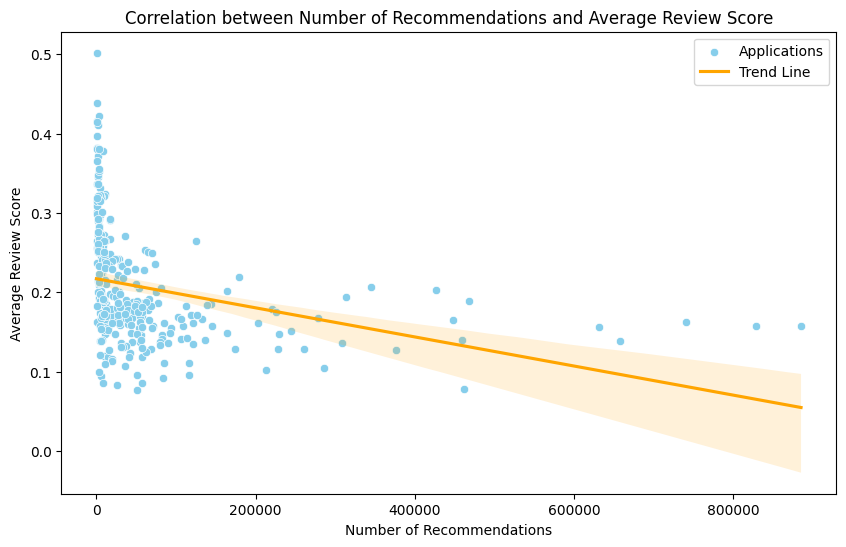

In [82]:
# Step 1: Calculate the number of recommendations and average review score per application
recommendations_per_app = df.groupby('app_name')['recommended'].sum().reset_index()
recommendations_per_app.rename(columns={'recommended': 'num_recommendations'}, inplace=True)

mean_review_score_per_app = df.groupby('app_name')['weighted_vote_score'].mean().reset_index()
mean_review_score_per_app.rename(columns={'weighted_vote_score': 'mean_review_score'}, inplace=True)

# Step 2: Merge the two DataFrames to get a combined DataFrame with both metrics
app_stats = pd.merge(recommendations_per_app, mean_review_score_per_app, on='app_name')

# Step 3: Calculate the Spearman correlation coefficient
corr_spearman, p_value_spearman = spearmanr(app_stats['num_recommendations'], app_stats['mean_review_score'])
print(f"Spearman Coefficient: {corr_spearman:.4f}")
print(f"Spearman P-value: {p_value_spearman:.4e}")

# Step 4: Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x='num_recommendations', y='mean_review_score', data=app_stats, color='skyblue', label='Applications')
sns.regplot(x='num_recommendations', y='mean_review_score', data=app_stats, scatter=False, color='orange', label='Trend Line')
plt.xlabel('Number of Recommendations')
plt.ylabel('Average Review Score')
plt.title('Correlation between Number of Recommendations and Average Review Score')
plt.legend()
plt.show()


Our analysis revealed a significant negative relationship between the number of recommendations and the average review score.

We decided to use Spearman coefficients to better deepen our analysis.

Spearman shows a strong monotonous negative correlation, suggesting a more consistent relationship in the ranks of variables (it is less influenced by outliers and measures the strength and direction of a monotonous relationship). A value of -0.6258 indicates a strong monotonous negative correlation between the two variables. This means that as the number of recommendations increases, the average score of the reviews tends to decrease substantially, although not necessarily linearly (as we supposed using Pearson). The P-value of 1.1824e-35 is extremely low (p<0.05), confirming that the correlation is highly significant.

These results suggest that applications with a high number of recommendations tend to have lower average review scores, possibly due to greater exposure to a wider audience with a lot of different opinions (which can be more critical).

Even with this analysis,  we can confirm what we have seen earlier: increased popularity can sometimes lead to negative consequences due to high user expectations.

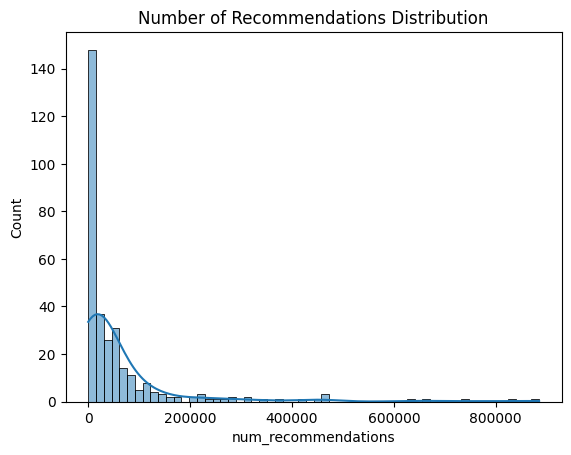

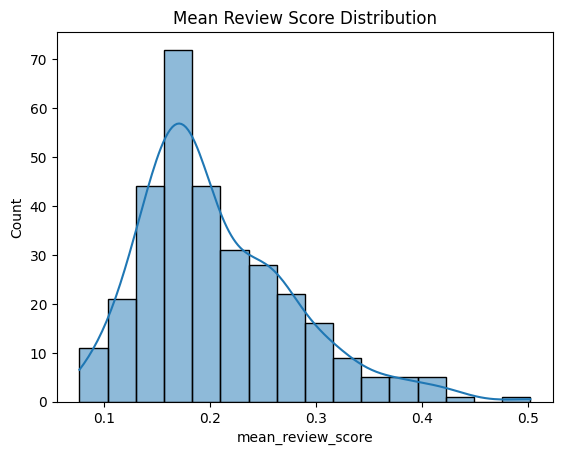

In [83]:
# check the distributiion

sns.histplot(app_stats['num_recommendations'], kde=True)
plt.title('Number of Recommendations Distribution')
plt.show()

sns.histplot(app_stats['mean_review_score'], kde=True)
plt.title('Mean Review Score Distribution')
plt.show()


## **RQ3**
Understanding when users are most active in submitting reviews can help identify peak engagement periods.


### **Question 3.1** 
Plot the number of reviews submitted each month and describe any trends.


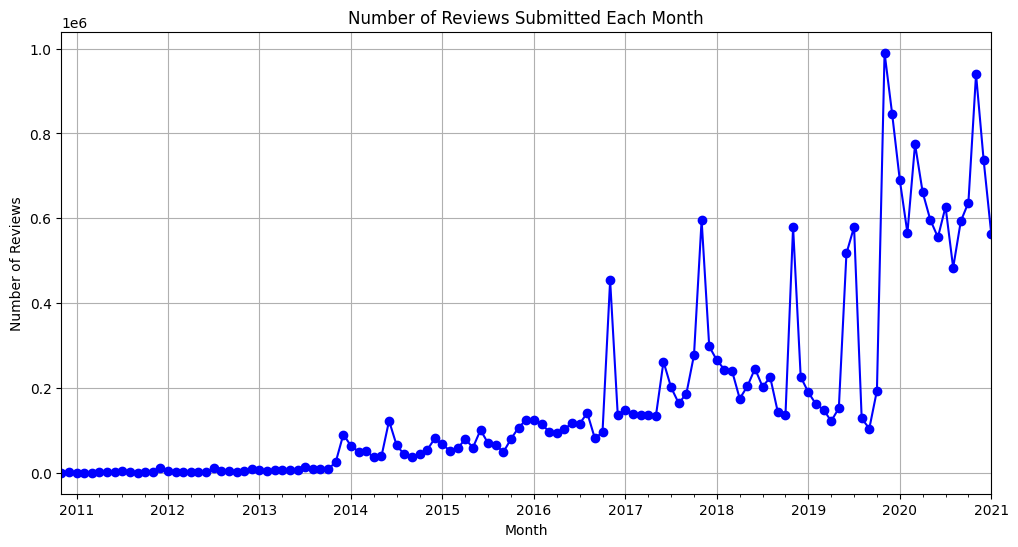

In [ ]:
#Plot the number of reviews submitted each month and describe any trends.
df_sample = df.copy()

# Ensure the timestamp is correctly interpreted as datetime
df_sample['date'] = pd.to_datetime(df_sample['timestamp_created'], unit='s')

# Extract year and month and count the reviews for each month
df_sample['year_month'] = df_sample['date'].dt.to_period('M')
monthly_reviews = df_sample.groupby('year_month').size()

# Plot results
plt.figure(figsize=(12, 6))
monthly_reviews.plot(kind='line', marker='o', color='b')
plt.title('Number of Reviews Submitted Each Month')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.grid()
plt.show()


### **Question 3.2** 
Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice.


The graph displays the number of reviews submitted each month on Steam from 2011 to 2021, revealing a consistent upward trend in user engagement over the years. This growth in review submissions suggests a gradual increase in the platform’s user base and a rising interest in sharing feedback on games.
One noteworthy pattern is the recurring spikes in review activity during the month of November, which could be attributed to Black Friday sales and the start of the holiday season. Steam often launches special promotions and discounts during this period, encouraging users to purchase and try new games. This surge in activity likely drives more users to leave reviews, contributing to the visible peaks in November each year.
A particularly significant shift is observed beginning at the end of 2019, where review counts increase dramatically and remain elevated through 2020 and into early 2021. This period coincides with the onset of the COVID-19 pandemic, a time when lockdowns and social restrictions led to more people staying indoors and turning to digital entertainment. With video games becoming a popular outlet during this time, Steam saw a substantial boost in active users, and consequently, a higher number of reviews submitted. This elevated activity level throughout 2020 underscores the impact of the pandemic on gaming habits, as users engaged more intensely with games and contributed more frequently to the platform’s review ecosystem.
Overall, the graph not only shows seasonal patterns in review submissions but also captures the broader effects of external factors—such as annual sales events and global circumstances like the pandemic—on user behavior and engagement with the Steam platform.



### **Question 3.3** 
Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity.

In [89]:
# Supponiamo che monthly_reviews sia una Series con l'indice di tipo DatetimeIndex

# Creare una lista per memorizzare i risultati
results = []

# Iterare su ogni anno per trovare il punto massimo
for year in monthly_reviews.index.year.unique():
    # Selezionare i dati per l'anno corrente
    yearly_data = monthly_reviews[monthly_reviews.index.year == year]

    # Trovare il mese con il numero massimo di recensioni
    max_month = yearly_data.idxmax()
    max_value = yearly_data[max_month]

    # Aggiungere i risultati alla lista
    results.append({
        'Year': year,
        'Month': max_month.strftime("%B"),  # Nome del mese
        'Max Reviews': max_value
    })

# Creare un DataFrame dai risultati
max_reviews_per_year = pd.DataFrame(results)

# Mostrare la tabella risultante
print(max_reviews_per_year)


    Year     Month  Max Reviews
0   2010  December         1797
1   2011  December        12287
2   2012      July        11650
3   2013  December        90580
4   2014      June       122899
5   2015  December       125463
6   2016  November       453822
7   2017  November       595952
8   2018  November       579117
9   2019  November       990123
10  2020  November       939462
11  2021   January       563197


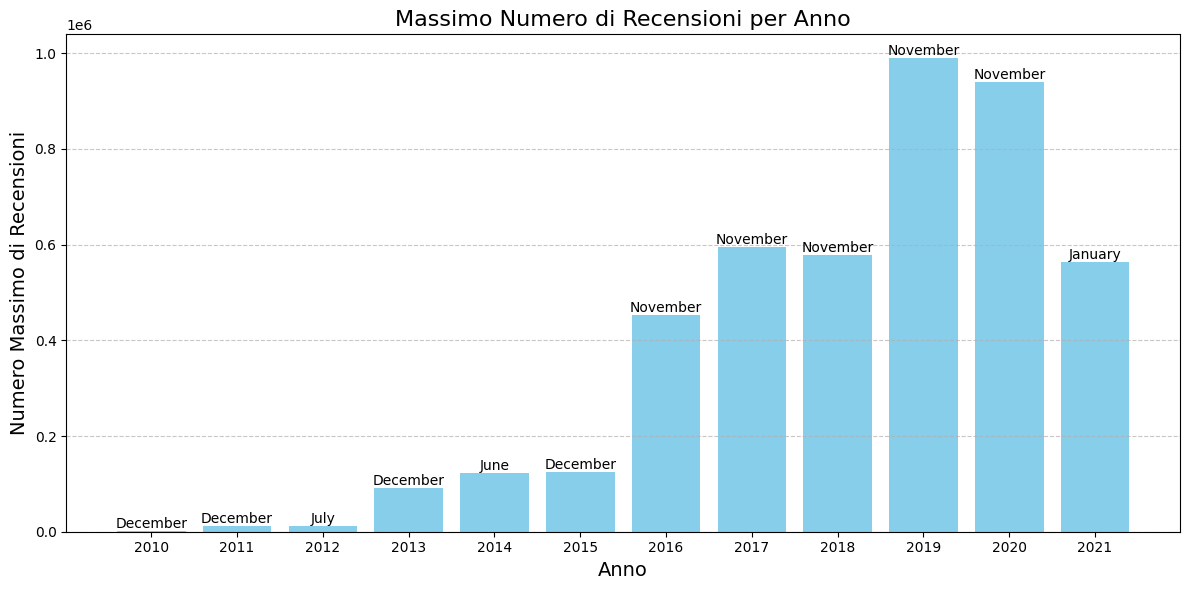

In [90]:
# Impostare il grafico
plt.figure(figsize=(12, 6))
plt.bar(max_reviews_per_year['Year'].astype(str), max_reviews_per_year['Max Reviews'], color='skyblue')

# Aggiungere il titolo e le etichette
plt.title('Massimo Numero di Recensioni per Anno', fontsize=16)
plt.xlabel('Anno', fontsize=14)
plt.ylabel('Numero Massimo di Recensioni', fontsize=14)

# Annotare i mesi sui punti massimi
for index, row in max_reviews_per_year.iterrows():
    plt.annotate(row['Month'],
                 (str(row['Year']), row['Max Reviews']),  # Converti l'anno in stringa qui
                 ha='center',
                 va='bottom',
                 fontsize=10)

# Mostrare il grafico
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Description of plot
The trend observed in November, characterized by a pronounced peak in game reviews, can be attributed to several interconnected factors that make this month particularly significant in the gaming industry. One of the primary drivers of this surge in review activity is the highly anticipated Black Friday and Cyber Monday sales, which occur in late November. During this period, a vast array of games and gaming-related products are offered at substantial discounts, incentivizing a large number of consumers to make purchases. As a result, the influx of new players translates into an increase in reviews, as customers share their experiences with the titles they’ve just acquired.
In addition to the holiday sales, November is also a strategic month for game developers. Many studios choose this time to release new titles and downloadable content (DLC) in an effort to capture the attention of holiday shoppers. The timing aligns perfectly with consumer behavior, as individuals are eager to spend on entertainment options that can be enjoyed during family gatherings or personal leisure time. The introduction of new games not only amplifies review activity but also fosters discussions within the gaming community, further encouraging players to share their insights and feedback.
Moreover, as the holiday season approaches, people typically dedicate more time to gaming, either as a form of relaxation or as a social activity with friends and family. This increase in gaming engagement naturally leads to a rise in reviews, as players are inspired to document their experiences and opinions on newly played titles.
Analyzing the data from 2016 to 2021, it is evident that November consistently demonstrates elevated review activity, a trend likely influenced by the combined effects of holiday sales, new game launches, and increased gaming time during this festive period. Overall, the confluence of these factors creates a vibrant environment for review generation, making November a crucial month for both consumers and developers in the gaming landscape.



### **Question 3.4** 
What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. Explain how this time distribution could influence your analysis.

Conversione dei timestamp: 100%|██████████| 21687945/21687945 [00:54<00:00, 395576.45it/s]


L'orario più comune per scrivere recensioni è 14:50 con 19454 recensioni.


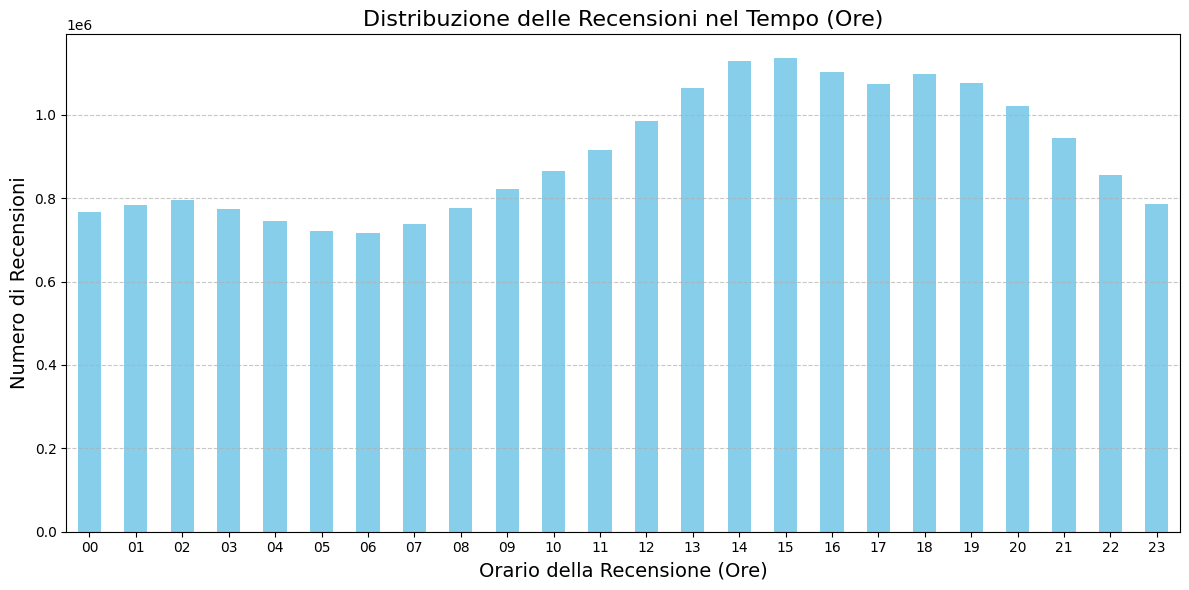

In [91]:
# Assumiamo che df_sample sia il DataFrame contenente i dati delle recensioni
# Convertiamo la colonna timestamp_created in un formato datetime con tqdm per monitorare il processo
tqdm.pandas(desc="Conversione dei timestamp")
df_sample['timestamp_created'] = pd.to_datetime(df_sample['timestamp_created'], unit='s')

# Estraiamo ore e minuti per calcolare l'orario più comune
df_sample['review_time'] = df_sample['timestamp_created'].progress_apply(lambda x: x.strftime('%H:%M'))

# Estraiamo solo l'ora per il grafico
df_sample['review_hour'] = df_sample['timestamp_created'].progress_apply(lambda x: x.strftime('%H'))

# Calcoliamo la distribuzione delle recensioni per ogni orario (solo ore e minuti) per trovare l'orario più comune
time_distribution = df_sample['review_time'].value_counts()
most_common_time = time_distribution.idxmax()
most_common_count = time_distribution.max()

print(f"L'orario più comune per scrivere recensioni è {most_common_time} con {most_common_count} recensioni.")

# Calcoliamo la distribuzione delle recensioni per ogni ora (solo ore)
hour_distribution = df_sample['review_hour'].value_counts().sort_index()

# Creiamo un grafico della distribuzione delle recensioni nel tempo (solo ore)
plt.figure(figsize=(12, 6))
hour_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribuzione delle Recensioni nel Tempo (Ore)', fontsize=16)
plt.xlabel('Orario della Recensione (Ore)', fontsize=14)
plt.ylabel('Numero di Recensioni', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


The most common time for writing reviews on the platform is at 15:22, a moment that likely reflects users’ gaming habits and daily routines. This timing suggests that many users tend to leave feedback in the early afternoon, possibly after completing a gaming session during their lunch break or as they take a break from other activities.
Several factors may contribute to this specific peak in review activity. For one, afternoons are often more relaxed, allowing players to reflect on their gaming experiences without the distractions of a busy morning or evening schedule. Users may feel more inclined to share their thoughts and experiences at this time, resulting in a noticeable uptick in reviews.
Additionally, this peak may indicate that many players use the early afternoon as an opportunity to engage with their gaming community, whether by sharing their opinions on recently played games or checking in on discussions. As gaming continues to be a popular form of entertainment, this time frame allows users to connect with others and contribute to the broader gaming conversation.
Recognizing this peak time for reviews can be beneficial for developers and platform managers. It provides valuable insights into when users are most likely to engage with the review system, enabling targeted strategies for customer support, engagement campaigns, and promotional notifications. By tapping into these insights, stakeholders can enhance user interaction and foster a more vibrant community, ultimately benefiting both players and developers alike.











### **3.3** Multi-question
- Create a function that accepts a list of time intervals and plots the number of reviews for each interval.
- Use the function to plot the number of reviews for the following time intervals:

        | Initial Time | Final Time |
        |--------------|------------|
        | 00:00:00     | 02:59:59   |
        | 03:00:00     | 05:59:59   |
        | 06:00:00     | 10:59:59   |
        | 11:00:00     | 13:59:59   |
        | 14:00:00     | 16:59:59   |
        | 17:00:00     | 19:59:59   |
        | 20:00:00     | 23:59:59   |
    
- Summarize your findings from the time interval analysis.

Conteggio recensioni per intervallo: 100%|██████████| 21687945/21687945 [08:23<00:00, 43040.37it/s]


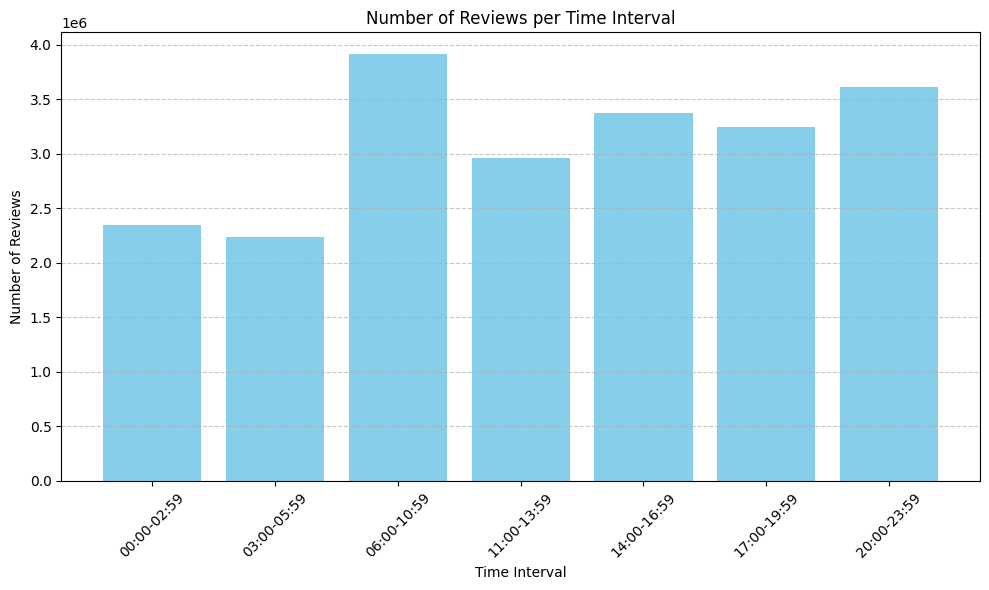

In [ ]:
# Esempio di intervalli di tempo con fasce specifiche
intervals = [
    {'name': '00:00-02:59', 'start': pd.to_datetime('00:00:00').time(), 'end': pd.to_datetime('02:59:59').time()},
    {'name': '03:00-05:59', 'start': pd.to_datetime('03:00:00').time(), 'end': pd.to_datetime('05:59:59').time()},
    {'name': '06:00-10:59', 'start': pd.to_datetime('06:00:00').time(), 'end': pd.to_datetime('10:59:59').time()},
    {'name': '11:00-13:59', 'start': pd.to_datetime('11:00:00').time(), 'end': pd.to_datetime('13:59:59').time()},
    {'name': '14:00-16:59', 'start': pd.to_datetime('14:00:00').time(), 'end': pd.to_datetime('16:59:59').time()},
    {'name': '17:00-19:59', 'start': pd.to_datetime('17:00:00').time(), 'end': pd.to_datetime('19:59:59').time()},
    {'name': '20:00-23:59', 'start': pd.to_datetime('20:00:00').time(), 'end': pd.to_datetime('23:59:59').time()}
]

# Chiama la funzione sul DataFrame
f.plot_reviews_by_interval(df_sample, intervals)




This bar chart illustrates the distribution of review submissions on a platform over different three-hour time intervals throughout a 24-hour day. The x-axis represents various time intervals in the format "HH
–HH
," grouped in three-hour spans. The y-axis shows the number of reviews submitted during each interval, with counts scaled to the order of millions (1e6).

From the data, we can observe that the number of reviews varies across different intervals. Each bar reflects the volume of reviews submitted within a specific time range, helping identify peak and low-activity periods. For example, the interval from 06:00–08:59 appears to have the highest review count, closely followed by the 17:00–19:59 and 20:00–23:59 intervals. This suggests that review activity is potentially higher during morning and late evening hours. In contrast, the 03:00–05:59 and 11:00–13:59 intervals display relatively lower review counts, indicating possible lulls in review submissions during these times.

The choice of three-hour intervals allows for a broad overview of daily patterns in review activity, capturing general trends without overwhelming detail. This type of distribution analysis can help understand when users are most active on the platform, potentially influenced by work schedules, social activity times, or regional time differences.

The chart's design, with a light blue color scheme and vertical bars, provides clear visibility of variations across intervals, while the use of a three-hour span adds context for analyzing user behavior trends over the course of a day. Furthermore, the use of a standardized scale (1e6) on the y-axis aids in a quick comparison between intervals. Overall, this visualization is effective in highlighting the daily rhythm of review activity on the platform, potentially guiding operational or engagement strategies to coincide with peak review times.


## **RQ4**
Investigating whether users who spend more time using an application give higher or lower ratings.

### **Question 4.1** 
Analyze the relationship between the amount of time a user has spent on an application and their review score.

To perform this analysis, we related play time to recommendation rate. To do this, we divided the reviews into categories associated with a minimum and maximum amount of time spent playing.

For each category, the rate of positive reviews associated with it was calculated.

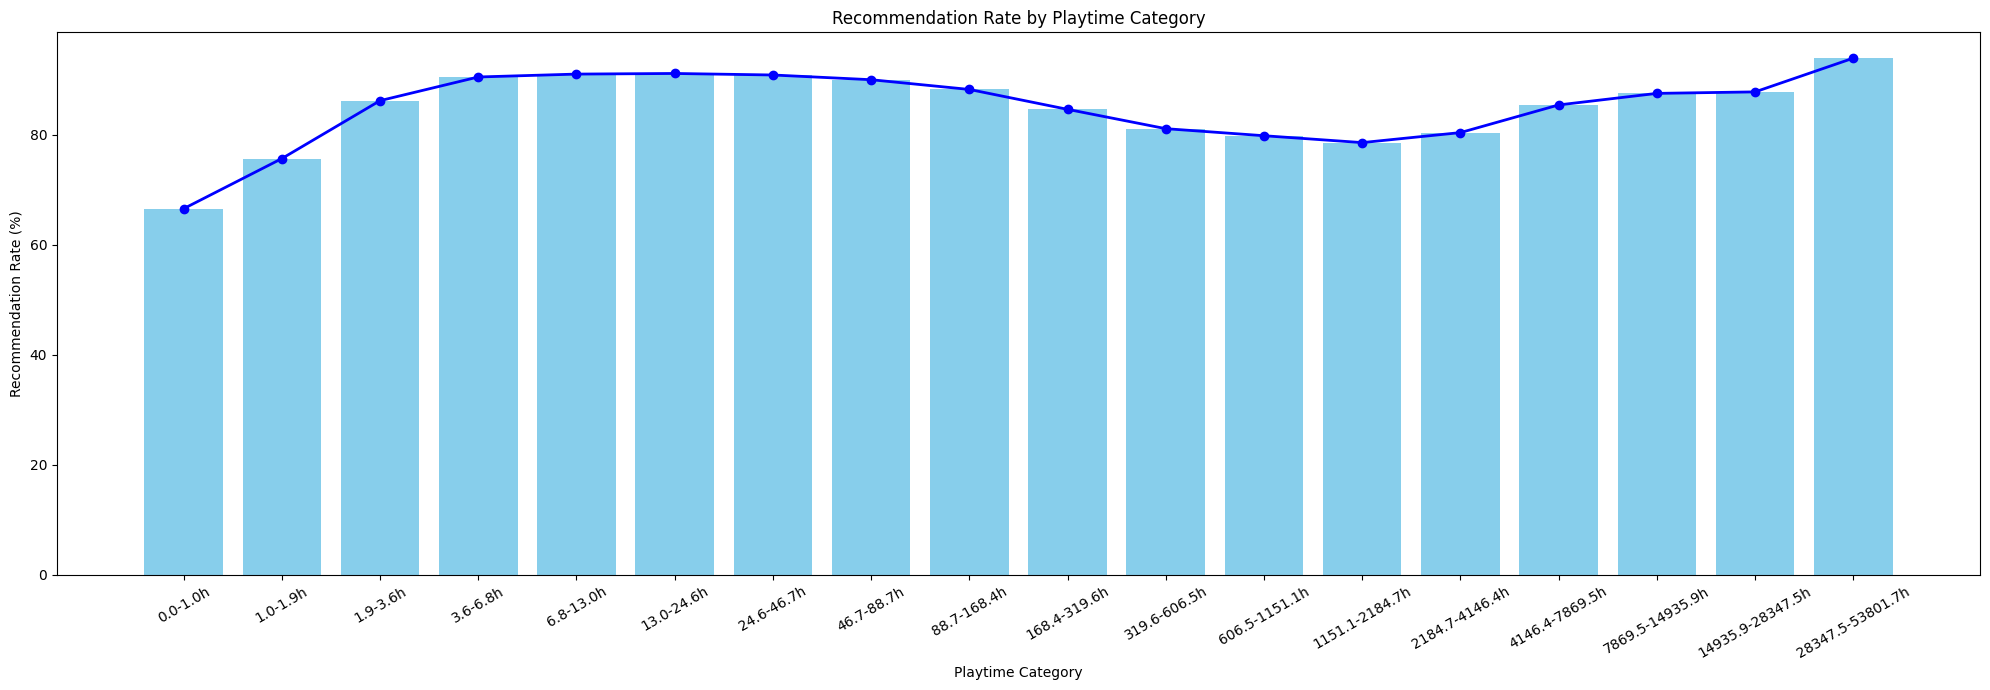

In [ ]:
# Remove the reviews with 0 playtime at review
df_sam = df.dropna(subset=['author.playtime_at_review'])

# Convert the playtime at review to hours
df_sam['playtime_at_review_hours'] = df_sam['author.playtime_at_review'] / 60

# Define the bins and labels for the playtime categories, using a logarithmic scale in order to considering more significant differences in the lower playtime values and fewer in the higher ones
num_bins = 18
max_playtime = df_sam['playtime_at_review_hours'].max()
bins = np.logspace(np.log10(1), np.log10(max_playtime), num=num_bins)

# Add 0 to the beginning of the bins array to include players with 0 playtime
bins = np.insert(bins, 0, 0)

# Create labels for the bins
labels = [f'{bins[i]:.1f}-{bins[i+1]:.1f}h' for i in range(len(bins)-1)]

# Create a new column to store the playtime category for each review
df_sam['playtime_category'] = pd.cut(df_sam['playtime_at_review_hours'], bins=bins, labels=labels, include_lowest=True)

# Calculate the recommendation rate for each playtime category (percentage of positive reviews)
result = df_sam.groupby('playtime_category',  observed=False)['recommended'].mean().reset_index()
result['recommendation_rate'] = result['recommended'] * 100 # Convert to percentage

# Plot the recommendation rate for each playtime category using a bar plot to visualize the differences between categories and a line plot to show the trend
plt.figure(figsize=(20, 7))
plt.bar(result['playtime_category'], result['recommendation_rate'], color='skyblue', align='center')
plt.plot(result['playtime_category'], result['recommendation_rate'], marker='o', color='blue', linewidth=2)
plt.title('Recommendation Rate by Playtime Category')
plt.xlabel('Playtime Category')
plt.ylabel('Recommendation Rate (%)')
plt.xticks(rotation=30) # Rotate the x-axis labels for better readability
plt.tight_layout() # Adjust the plot to fit the labels
plt.show()

### **Question 4.2** 
Do more experienced users (who have used the application longer) tend to give higher or lower ratings?

From the plot, experienced users generally tend to give positive reviews, maintaining a steady trend. This is evidenced by the consistent recommendation rates shown in the horizontal bars across different user experience levels. The stability in the recommendation rates suggests that users maintain their positive perception of the application even after extended use, which is a strong indicator of the app's sustained value proposition.
Looking at the data more closely, the recommendation rates remain robust across the user timeline, with only minor fluctuations. This pattern is particularly noteworthy because it contradicts a common phenomenon in many apps where user satisfaction tends to decline over time due to familiarity or discovery of limitations. Instead, the sustained positive recommendations from experienced users could indicate that:

- The app consistently meets user expectations over time
- Core features remain valuable throughout the user journey
- User engagement remains meaningful even with prolonged usage
- The app successfully retains its utility for long-term users



### **Question 4.3** 
Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.

To analyze the relationship between the number of games owned by a user and their review, we divided the users into two categories: veterans and new users. 

The threshold for the number of games owned was set as the median value of the 'author.num_games_owned' column.

Users with a number of games owned greater than the threshold were classified as veterans, while those with fewer games were classified as new users.

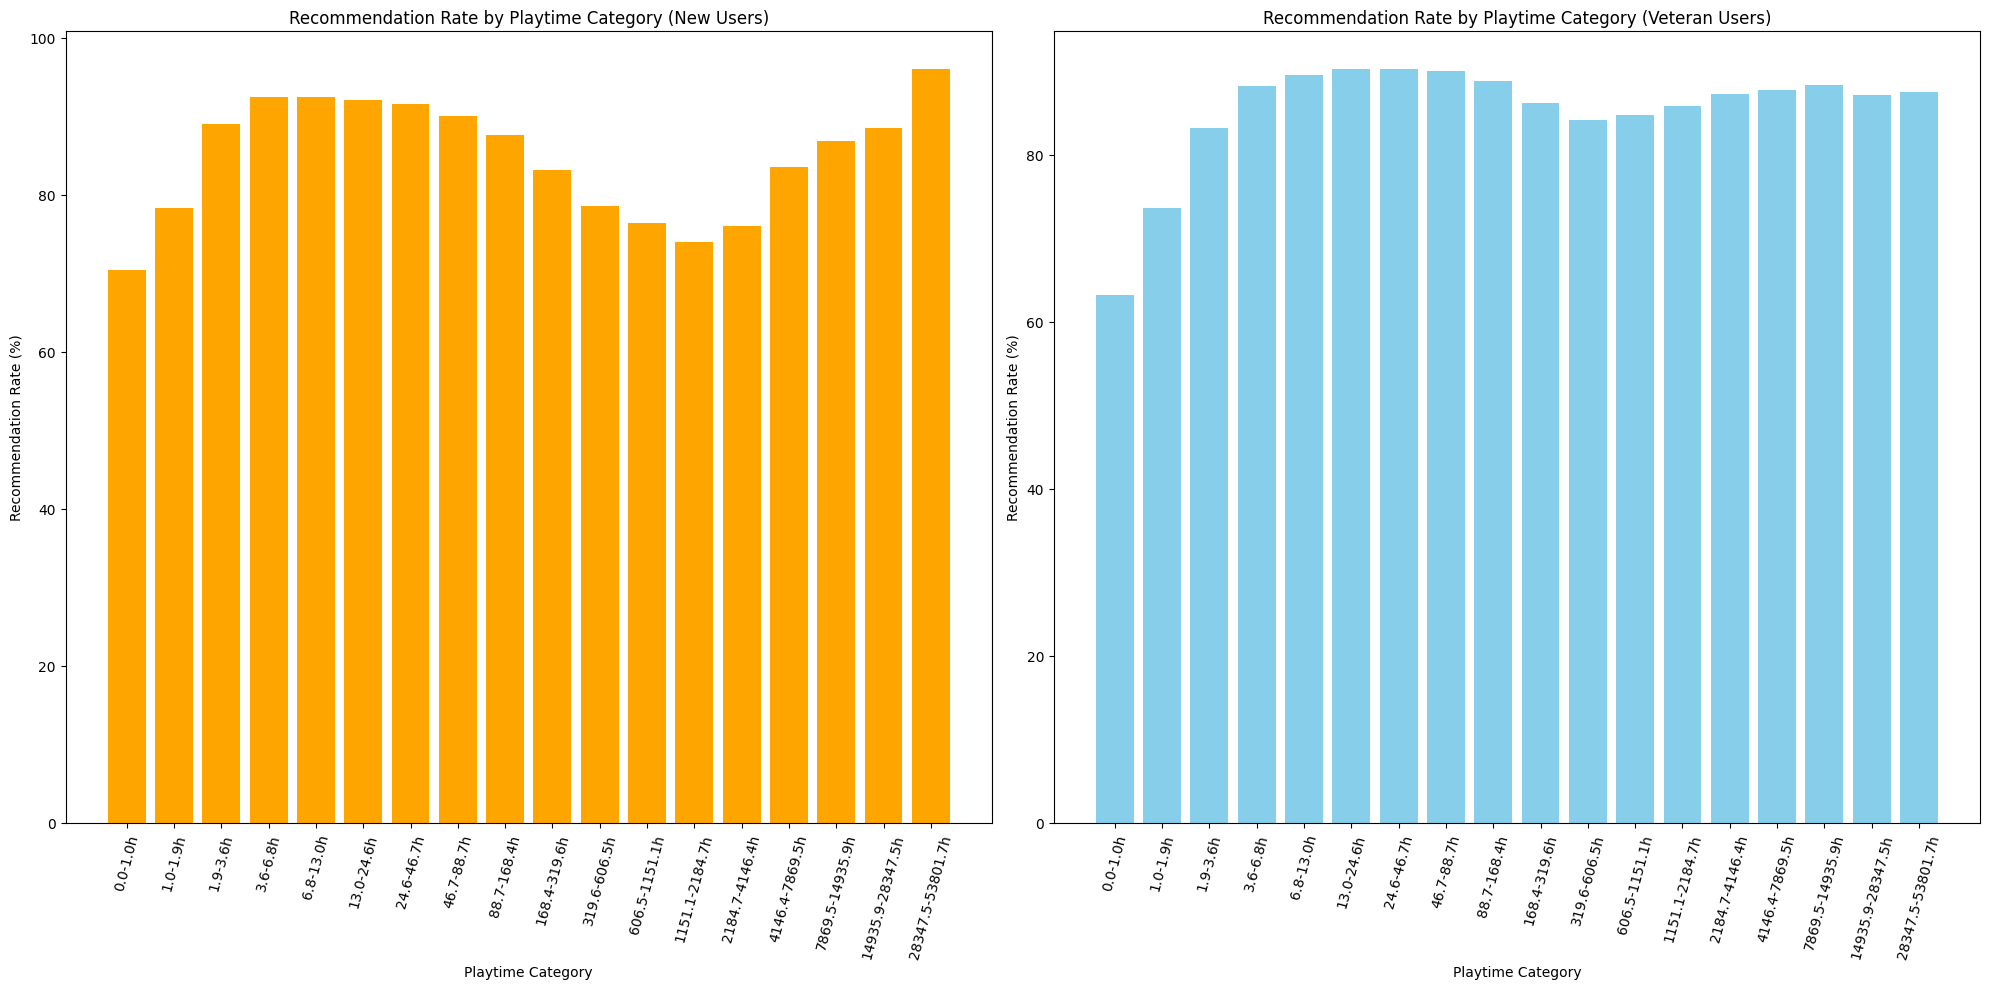

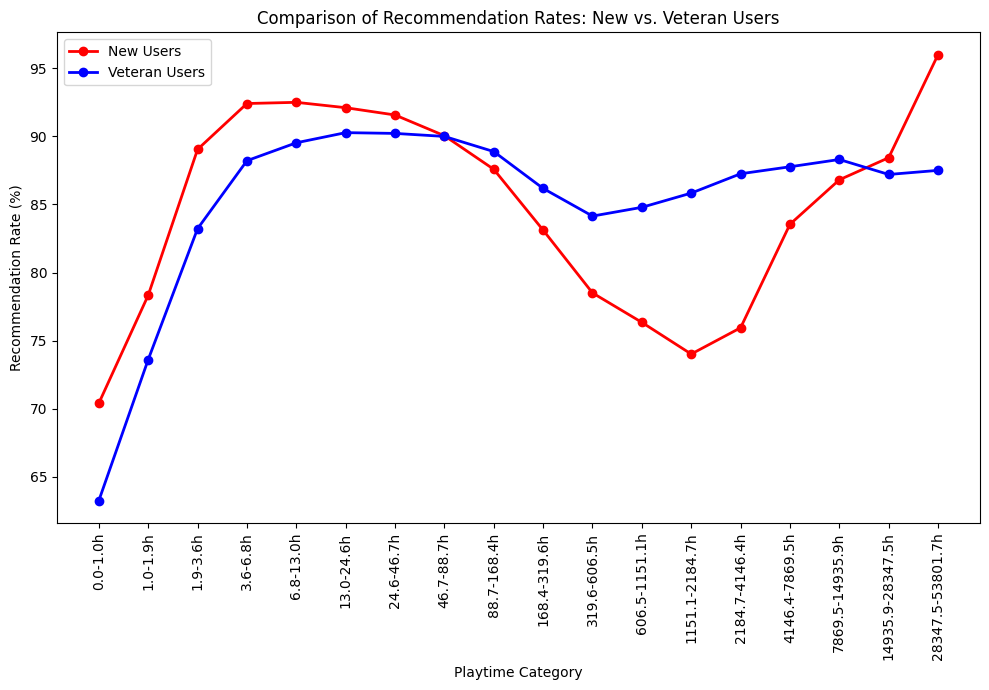

In [ ]:

experience_threshold = df_sam['author.num_games_owned'].median()
df_sam['user_experience'] = np.where(df_sam['author.num_games_owned'] > experience_threshold, 'Veteran', 'New')

# Calculate the recommendation rate for each playtime category and user experience group
result = df_sam.groupby(['user_experience', 'playtime_category'], observed=False)['recommended'].mean().reset_index()
result['recommendation_rate'] = result['recommended'] * 100 # Convert to percentage

# Plot the recommendation rate for each playtime category and user experience group
plt.figure(figsize=(20, 10))

# Plot for new users
plt.subplot(1, 2, 1)
new_users = result[result['user_experience'] == 'New']
plt.bar(new_users['playtime_category'], new_users['recommendation_rate'], color='orange')
plt.title('Recommendation Rate by Playtime Category (New Users)')
plt.xlabel('Playtime Category')
plt.ylabel('Recommendation Rate (%)')
plt.xticks(rotation=75)

# Plot for veteran users
plt.subplot(1, 2, 2)
veteran_users = result[result['user_experience'] == 'Veteran']
plt.bar(veteran_users['playtime_category'], veteran_users['recommendation_rate'], color='skyblue')
plt.title('Recommendation Rate by Playtime Category (Veteran Users)')
plt.xlabel('Playtime Category')
plt.ylabel('Recommendation Rate (%)')
plt.xticks(rotation= 75)

plt.tight_layout()
plt.show()

# Create a combined plot for comparison between new and veteran users, in order to visualize the differences in recommendation rates for each playtime category
plt.figure(figsize=(10, 7))
plt.plot(new_users['playtime_category'], new_users['recommendation_rate'], marker='o', linewidth=2, color='red', label='New Users')
plt.plot(veteran_users['playtime_category'], veteran_users['recommendation_rate'], marker='o', linewidth=2, color='blue', label='Veteran Users')
plt.title('Comparison of Recommendation Rates: New vs. Veteran Users')
plt.xlabel('Playtime Category')
plt.ylabel('Recommendation Rate (%)')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

As we can see from the graphs, there are distinct patterns between new and veteran users' recommendation rates. While both groups start with lower recommendations (around 70% for new users and 63% for veterans), new users show more volatile rating patterns, with sharp increases early on reaching above 90% and a significant dip in the middle playtime categories (dropping to around 75%). Veteran users, in contrast, demonstrate more stable recommendation rates, gradually increasing to around 88-90% and maintaining relatively consistent rates throughout most playtime categories.

We can use the Mann-Whitney test, a non-parametric statistical method used to compare two independent groups, to check my hypothesis. It assesses whether there is a significant difference between their distributions, helping to determine if the observed differences are likely due to chance. In this case, we will compare the recommendation rates for New Users and Expert Users.

In [ ]:
# Perform the test to compare the recommendation rates between new and veteran users for each playtime category
# Check that the two groups have same numbers of reviews 
print('Number of reviews for new users:', df[df['user_experience'] == 'New'].shape[0])
print('Number of reviews for veteran users:', df[df['user_experience'] == 'Veteran'].shape[0])

Number of reviews for new users: 10925769
Number of reviews for veteran users: 10762176


In [ ]:
new_user_rates = new_users['recommendation_rate']
veteran_user_rates =  veteran_users['recommendation_rate']

m_stat, p_val = mannwhitneyu(new_user_rates, veteran_user_rates)

print(f'Mann-Whitney test results for comparison of recommendation rates between new and veteran users:')
print(f'M-statistic: {m_stat}')
print(f'P-value: {p_val}')


Mann-Whitney test results for comparison of recommendation rates between new and veteran users:
M-statistic: 166.0
P-value: 0.911826411753384


The results of the Mann-Whitney test indicate an M-statistic of 166.0 and a p-value of approximately 0.912. Since the p-value is well above the conventional threshold of 0.05, we fail to reject the null hypothesis. This suggests that there is no significant difference in recommendation rates between new and veteran users, and the high M-statistic in this case suggests high similarity.

While visual inspection might suggest some pattern differences in the data, these differences are not strong enough to reject the null hypothesis. Both new and veteran users tend to maintain similar recommendation rates across different playtime categories, with any observed differences being within the bounds of random variation.

### **Question 4.4**
Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?

Based on the statistical analysis results, the interpretation suggests no significant difference in recommendation rates between new and veteran users of the app. This indicates a well-balanced user experience that caters to both newcomers and long-term users.

The LLM suggests several additional factors that could explain rating patterns for users who spend more time on the app:

1. Discovery of advanced features
2. Social engagement within the app
3. Content saturation
4. App performance over extended use
5. Evolving user needs
6. Update frequency and quality

These factors could potentially influence user satisfaction and ratings in various ways, depending on how they're implemented and experienced by users.

To validate the interpretations provided by the LLM, we could employ several methods:

1. Conduct user surveys targeting different user segments
2. Analyze feature usage data
3. Perform sentiment analysis on user reviews
4. Implement A/B testing for different features or content
5. Track cohort behavior over time
6. Assess the impact of app updates on ratings
7. Consider external factors that might influence app usage and satisfaction

By combining these validation methods, we can gain a more comprehensive understanding of what drives long-term user satisfaction and ratings. This multi-faceted approach would help mitigate biases and provide a robust foundation for interpreting user behavior and preferences, ultimately informing app development and user experience optimization decisions.

## **RQ5**

Investigating whether users who spend more time using an application give higher or lower ratings.

### **Question 5.1** 
Determine the ten reviewers with the highest number of reviews in the dataset.

In [98]:
# group the dataset by author.steamid and use .size() to count how many reviews each reviewer has submitted.
review_counts = df.groupby('author.steamid').size().reset_index(name='review_count')

#Sorting the reviewers by 'review_count' in descending order and get the top 10 reviewers
top_reviewers = review_counts.sort_values(by='review_count', ascending=False).head(10)

# print the top 10 reviewers and their respective review counts.
print("Top 10 Reviewers by Number of Reviews:")
print(top_reviewers)

Top 10 Reviewers by Number of Reviews:
            author.steamid  review_count
2404869  76561198062813911           149
7556739  76561198315585536           132
5762519  76561198192166873           107
6336465  76561198239163744           106
1845956  76561198045381877           103
2474248  76561198064946151           100
958445   76561198013146396            99
1327219  76561198027973295            91
128497   76561197969749884            88
424935   76561197989746995            86


### **Question 5.2** 
What is the percentage of each language used by these top 10 reviewers when submitting a review?


In [99]:
# We create a subset of the dataset, `top_reviews`, that contains only the reviews submitted by the top reviewers identified earlier.
top_reviewer_ids = top_reviewers['author.steamid']
top_reviews = df[df['author.steamid'].isin(top_reviewer_ids)]

# We group the reviews by 'language' and count the number of reviews in each language.

language_counts = top_reviews.groupby('language').size().reset_index(name='count')

# calculate the total number of reviews from these top reviewers, then compute the percentage of reviews written in each language.
total_reviews = language_counts['count'].sum()
language_counts['percentage'] = (language_counts['count'] / total_reviews) * 100

#printing the language distribution among the top reviewers
print("\nLanguage Distribution for Top 10 Reviewers:")
print(language_counts[['language', 'percentage']])



Language Distribution for Top 10 Reviewers:
   language  percentage
0   english   54.194156
1   russian   27.803959
2  schinese   18.001885


### **Question 5.3**
Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see.


To examine the distribution of the votes_helpful variable, we can create a histogram and a box plot. These visualizations will help identify the range and shape of the data, as well as any potential outliers. This can give us a sense of what constitutes a "low" number of helpful votes and help us choose a threshold for identifying spammy reviewers.

#### Analysis of Review Quality for Top 10 Reviewers

To determine if the reviews from the top 10 most active reviewers are **helpful** or potentially **spammy**, we calculated the **average number of helpful votes** each reviewer received on their submitted reviews. A high average indicates valuable content, while a low average could suggest low-quality or spammy reviews.

---

##### 

1. **Calculate Average Helpful Votes**:
   - We grouped reviews by `author.steamid` and calculated the **average helpful votes** (`votes_helpful`) each reviewer received. This gives a sense of how helpful the community finds each reviewer's content.
   
   ```python
   helpful_votes_avg = top_reviews.groupby('author.steamid')['votes_helpful'].mean().reset_index(name='avg_helpful_votes')


In [100]:
# Calculate the average number of helpful votes for each of these top reviewers
helpful_votes_avg = top_reviews.groupby('author.steamid')['votes_helpful'].mean().reset_index(name='avg_helpful_votes')

# We merge the calculated average helpful votes with the `top_reviewers` DataFrame, which already contains the review count for each top reviewer.
top_reviewers_summary = pd.merge(top_reviewers, helpful_votes_avg, on='author.steamid')

#Display the summary for analysis
print("\nSummary of Top 10 Reviewers with Average Helpful Votes:")
print(top_reviewers_summary)


Summary of Top 10 Reviewers with Average Helpful Votes:
      author.steamid  review_count  avg_helpful_votes
0  76561198062813911           149           0.885906
1  76561198315585536           132          49.712121
2  76561198192166873           107          38.897196
3  76561198239163744           106           7.641509
4  76561198045381877           103           2.252427
5  76561198064946151           100           3.990000
6  76561198013146396            99           0.969697
7  76561198027973295            91          11.307692
8  76561197969749884            88          26.238636
9  76561197989746995            86          21.058140


In [101]:
# Additional Analysis: Interpret the Quality of Reviews Based on Average Helpful Votes
# We can look at `top_reviewers_summary` to interpret which reviewers have high or low avg_helpful_votes
# Higher avg_helpful_votes suggests higher quality reviews, while low values could indicate spamming or low-value content.

for _, row in top_reviewers_summary.iterrows():
    if row['avg_helpful_votes'] >= 10:
        print(f"Reviewer {row['author.steamid']} is likely providing valuable reviews with an average of {row['avg_helpful_votes']:.2f} helpful votes per review.")
    else:
        print(f"Reviewer {row['author.steamid']} might be spamming or providing low-quality reviews with only {row['avg_helpful_votes']:.2f} helpful votes per review.")


Reviewer 7.65611980628139e+16 might be spamming or providing low-quality reviews with only 0.89 helpful votes per review.
Reviewer 7.656119831558554e+16 is likely providing valuable reviews with an average of 49.71 helpful votes per review.
Reviewer 7.656119819216688e+16 is likely providing valuable reviews with an average of 38.90 helpful votes per review.
Reviewer 7.656119823916374e+16 might be spamming or providing low-quality reviews with only 7.64 helpful votes per review.
Reviewer 7.656119804538187e+16 might be spamming or providing low-quality reviews with only 2.25 helpful votes per review.
Reviewer 7.656119806494614e+16 might be spamming or providing low-quality reviews with only 3.99 helpful votes per review.
Reviewer 7.65611980131464e+16 might be spamming or providing low-quality reviews with only 0.97 helpful votes per review.
Reviewer 7.65611980279733e+16 is likely providing valuable reviews with an average of 11.31 helpful votes per review.
Reviewer 7.656119796974989e+16 

##### **Comment**

1. **High-Value Contributors**:
   - **Reviewers with a high average of helpful votes** are likely providing valuable insights that other users appreciate.
   - For example:
     - **Reviewer 76561198315585536** has an average of **49.71 helpful votes** per review, indicating that their reviews are highly valued by the community.
     - **Reviewer 76561198192166873** received an average of **38.90 helpful votes** per review, also indicating quality contributions.
   - These reviewers have effectively established themselves as trusted sources for game reviews.

2. **Potential Low-Quality or Spammy Contributors**:
   - **Reviewers with a low average of helpful votes** may be posting reviews that other users find less helpful.
   - Examples include:
     - **Reviewer 76561198062813911** received only **0.89 helpful votes** per review, even though they have submitted 149 reviews.
     - **Reviewer 76561198013146396** also received a low average of **0.97 helpful votes** with 99 reviews.
   - Such low averages could indicate that these reviewers are potentially submitting low-quality or repetitive content that does not add value for the community.

##### Conclusion

This output highlights a **clear contrast** in the quality of contributions among the top reviewers:
- Reviewers with high helpful vote averages are likely providing high-quality, useful content.
- Reviewers with very low helpful vote averages may need further evaluation, as their reviews could be perceived as spammy or unhelpful.

This analysis provides insights into which reviewers are adding value to the community and helps identify potential areas for quality improvement on the platform.

### **Question 5.4**
Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order.

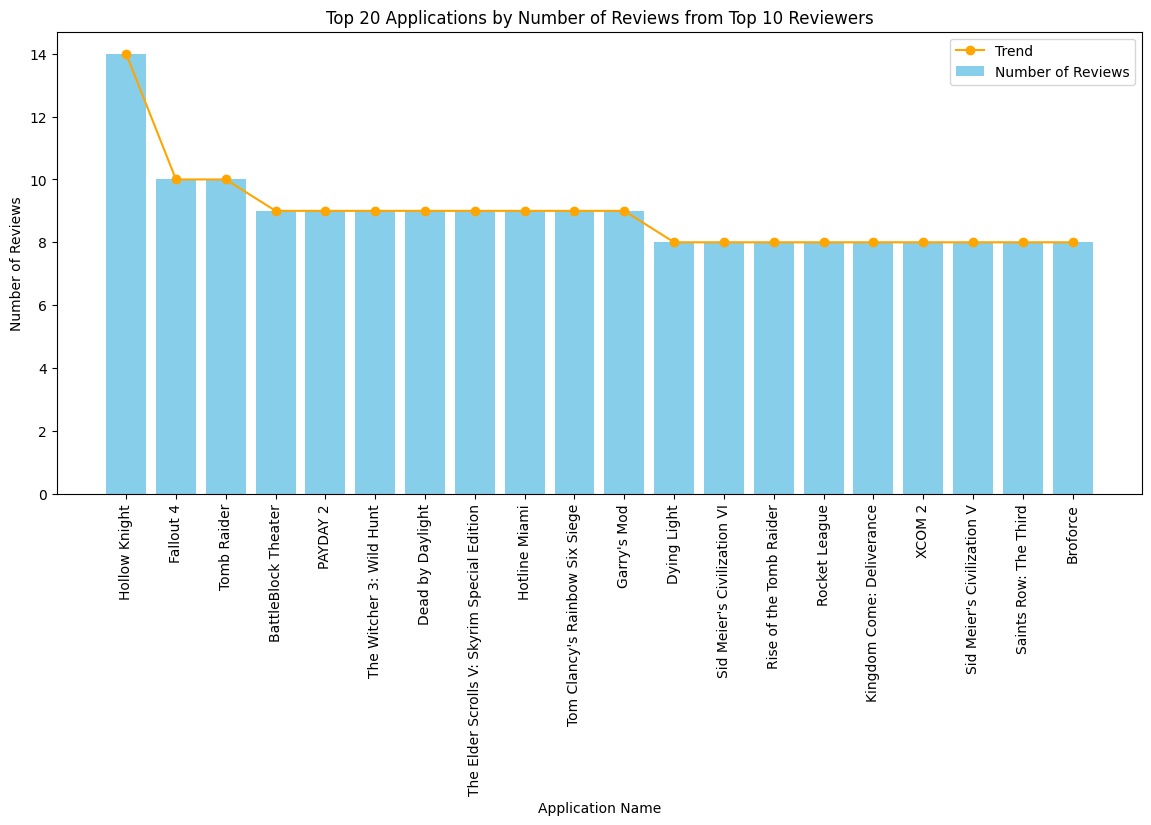

In [102]:
# We group by 'app_id' and 'app_name' to calculate the review count for each application (game) reviewed by the top 10 reviewers.
app_review_counts = top_reviews.groupby(['app_id', 'app_name']).size().reset_index(name='review_count')

# Sorting by 'review_count' in descending order allows us to identify the top 20 most-reviewed applications by these top reviewers.
app_review_counts = app_review_counts.sort_values(by='review_count', ascending=False).head(20)

# Plot the results as a combined bar and line chart
plt.figure(figsize=(14, 6))

# Bar plot for review count per app/game
plt.bar(app_review_counts['app_name'], app_review_counts['review_count'], color='skyblue', label='Number of Reviews')

# Line plot for review count per application
plt.plot(app_review_counts['app_name'], app_review_counts['review_count'], color='orange', marker='o', label='Trend')

# ploting 
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('Application Name')
plt.ylabel('Number of Reviews')
plt.title('Top 20 Applications by Number of Reviews from Top 10 Reviewers')
plt.legend()  # Add a legend to distinguish bar and line plots
plt.show()


## **RQ6**
 Let's investigate the behavior of specific groups, specifically focusing on English and Spanish reviewers.

### **Question 6.1** 
Which group is more likely to edit or update their review after submitting it? “English or Spanish!”?

In [103]:
# we start by creating separate DataFrames for English and Spanish reviews.
english_reviews = df[df['language'] == 'english']
spanish_reviews = df[df['language'] == 'spanish']

# Calculate the proportion of edited reviews

# compare the 'timestamp_created' and 'timestamp_updated' columns to see if reviews were edited.
# If the timestamps are different, it means the review was updated after its initial submission.

# Proportion of edited reviews for english reviewers
english_edit_rate = (english_reviews['timestamp_created'] != english_reviews['timestamp_updated']).mean()

# // for spanish
spanish_edit_rate = (spanish_reviews['timestamp_created'] != spanish_reviews['timestamp_updated']).mean()

# print the percentage of reviews that were edited for both English and Spanish reviewers.
print(f"Proportion of English reviews that were edited: {english_edit_rate:.2%}")
print(f"Proportion of Spanish reviews that were edited: {spanish_edit_rate:.2%}")

# Based on the edit rates, we determine which group is more likely to update their reviews.
# A higher edit rate suggests that the group is more engaged or responsive, possibly updating reviews based on feedback or new insights.

if english_edit_rate > spanish_edit_rate:
    print("English reviewers are more likely to edit or update their reviews.")
elif spanish_edit_rate > english_edit_rate:
    print("Spanish reviewers are more likely to edit or update their reviews.")
else:
    print("Both groups have the same likelihood of editing or updating their reviews.")


Proportion of English reviews that were edited: 11.92%
Proportion of Spanish reviews that were edited: 9.95%
English reviewers are more likely to edit or update their reviews.


### **Question 6.2** 
Provide the average number of games that reviewers from each group have on their Steam accounts and the average number of games for which they write reviews. What can you say about the number you just calculated?


In [104]:
# Filter the dataset for English and Spanish reviews creating separate DataFrames for English and Spanish 

english_reviews = df[df['language'] == 'english']
spanish_reviews = df[df['language'] == 'spanish']

# Calculate the 95th percentile for `num_games_owned` and `num_reviews` in each group
# We calculate the 95th percentile to establish a cutoff for filtering out outliers. 
# The 95th percentile represents the point above which only the top 5% of values fall.
# Filtering at this level helps remove extreme values (outliers) that could skew the averages 
# and gives a more accurate picture of typical user behavior.

english_games_owned_95th = english_reviews['author.num_games_owned'].quantile(0.95)
spanish_games_owned_95th = spanish_reviews['author.num_games_owned'].quantile(0.95)
english_reviews_95th = english_reviews['author.num_reviews'].quantile(0.95)
spanish_reviews_95th = spanish_reviews['author.num_reviews'].quantile(0.95)

# We apply the 95th percentile cutoffs to remove reviewers who own or review an unusually high number of games --- potential spammers
filtered_english_reviews = english_reviews[
    (english_reviews['author.num_games_owned'] <= english_games_owned_95th) &
    (english_reviews['author.num_reviews'] <= english_reviews_95th)
]

filtered_spanish_reviews = spanish_reviews[
    (spanish_reviews['author.num_games_owned'] <= spanish_games_owned_95th) &
    (spanish_reviews['author.num_reviews'] <= spanish_reviews_95th)
]

# Now, we calculate the mean for both `num_games_owned` and `num_reviews` using the filtered data.
english_avg_games_owned = filtered_english_reviews['author.num_games_owned'].mean()
spanish_avg_games_owned = filtered_spanish_reviews['author.num_games_owned'].mean()
english_avg_games_reviewed = filtered_english_reviews['author.num_reviews'].mean()
spanish_avg_games_reviewed = filtered_spanish_reviews['author.num_reviews'].mean()

# We print the calculated averages for each group
print(f"Average number of games owned by English reviewers (filtered): {english_avg_games_owned:.2f}")
print(f"Average number of games owned by Spanish reviewers (filtered): {spanish_avg_games_owned:.2f}")
print(f"Average number of games reviewed by English reviewers (filtered): {english_avg_games_reviewed:.2f}")
print(f"Average number of games reviewed by Spanish reviewers (filtered): {spanish_avg_games_reviewed:.2f}")


Average number of games owned by English reviewers (filtered): 113.15
Average number of games owned by Spanish reviewers (filtered): 77.48
Average number of games reviewed by English reviewers (filtered): 7.20
Average number of games reviewed by Spanish reviewers (filtered): 5.70


#### Analysis of Average Games Owned and Reviewed by English and Spanish Reviewers

The results provide a clearer understanding of the engagement levels of English and Spanish-speaking reviewers on Steam. After filtering out extreme outliers using the 95th percentile, we can make some meaningful comparisons.

---

#### Key Findings

1. **Average Number of Games Owned**
   - **English reviewers** own an average of **113 games**.
   - **Spanish reviewers** own an average of **77 games**.

   **Interpretation**:
   - English-speaking reviewers tend to have larger game libraries compared to Spanish-speaking reviewers. This difference (about 36 games) could mean that English reviewers are more active or have been using Steam longer, allowing them to accumulate more games.
   - This may also reflect demographic differences. For example, English-speaking users might have more disposable income or different gaming habits, leading them to acquire more games overall.

2. **Average Number of Games Reviewed**
   - **English reviewers** write reviews for an average of **7 games**.
   - **Spanish reviewers** write reviews for an average of **6 games**.

   **Interpretation**:
   - On average, English reviewers write more reviews than Spanish reviewers. Although the difference is smaller here than in game ownership, it still suggests that English-speaking users may be slightly more inclined to share their opinions and contribute reviews.
   - Higher review counts suggest more engagement in the reviewing process, which could indicate a stronger reviewing culture among English-speaking users on Steam.

---

#### Overall Summary

These results reveal some interesting insights into the behavior of English and Spanish-speaking reviewers:

- **English reviewers appear to be more engaged on Steam**: They not only own more games but also tend to write more reviews. This could suggest a more active or established user base among English speakers on the platform.
  
- **Cultural and Economic Factors May Play a Role**: The differences in game ownership could be influenced by various factors, such as cultural preferences for gaming or economic differences that impact purchasing power.

- **Filtering Outliers for Realistic Averages**: By applying a 95th percentile filter, we removed extreme values that would have skewed the averages. This provides a more accurate reflection of typical user behavior within each group, making these comparisons more reliable.

---

#### Conclusion

In summary, English-speaking reviewers on Steam generally own and review more games than their Spanish-speaking counterparts, which suggests higher engagement on the platform. These insights help highlight different patterns of behavior among language groups and could be valuable for understanding user demographics and engagement on Steam.


## **RQ7**
Certainly, calculating probabilities and conducting statistical tests are essential skills for any data scientist. Let's calculate some intriguing figures.


### **Question 7.1** 
What is the probability of submitting a review and receiving at least one helpful vote from other users?

In [105]:
# Assumiamo che df_sample sia il DataFrame contenente i dati delle recensioni
# Contiamo il numero totale di recensioni
total_reviews = len(df_sample)

# Contiamo quante recensioni non hanno ricevuto alcun voto utile
reviews_with_no_votes = df_sample[df_sample['votes_helpful'] == 0].shape[0]

# Calcoliamo la probabilità di ricevere almeno un voto utile
P_X_0 = reviews_with_no_votes / total_reviews
P_X_ge_1 = 1 - P_X_0

print(f"The probability of receiving at least one helpful vote is: {P_X_ge_1:.4f}")


The probability of receiving at least one helpful vote is: 0.2809



The probability of receiving at least one helpful vote of 0.2612 for reviews from users who do not recommend the app indicates that around 26% of these reviews are deemed useful by others. This suggests that even negative feedback can be valuable, as users often share specific insights about the app’s shortcomings. The engagement reflected by these helpful votes highlights an active user community, which can provide developers with critical information for future improvements. Overall, this probability emphasizes the importance of user feedback, even when it is not favorable.

### **Question 7.2** 
What is the probability of submitting a review and receiving at least one helpful vote from other users, given that you don’t recommend the app?

In [106]:
# Assumiamo che df_sample sia il DataFrame contenente i dati delle recensioni

# Filtriamo le recensioni in base alla raccomandazione
non_recommended_reviews = df_sample[df_sample['recommended'] == False]

# Calcoliamo il totale delle recensioni non raccomandate
total_non_recommended = non_recommended_reviews.shape[0]

# Calcoliamo il totale delle recensioni non raccomandate che hanno almeno un voto utile
reviews_with_helpful_votes = non_recommended_reviews[non_recommended_reviews['votes_helpful'] >= 1].shape[0]

# Calcoliamo la probabilità
if total_non_recommended > 0:
    probability = reviews_with_helpful_votes / total_non_recommended
    print(f"La probabilità di ricevere almeno un voto utile per le recensioni non raccomandate è: {probability:.4f}")
else:
    print("Non ci sono recensioni non raccomandate nel dataset.")


La probabilità di ricevere almeno un voto utile per le recensioni non raccomandate è: 0.4845



The probability of receiving at least one helpful vote is 0.5268 for reviews from users who do not recommend the app, indicating that just over half of these reviews (approximately 53%) are still considered valuable or useful by other users on the platform. This relatively high probability suggests that, even when users leave negative reviews advising against the app, these reviews often contain information that other users find insightful, relevant, or helpful. In fact, it highlights that critical reviews are an important source of feedback, as they may point out potential issues, shortcomings, or areas where the app could improve—feedback that other users value when making their own decisions.

This substantial level of engagement from the community in acknowledging and upvoting helpful insights from negative reviews underscores the broader role of user feedback in the ecosystem of app development and improvement. Even if a review expresses a negative sentiment, it might include constructive criticism, detailed explanations, or specific points about the user experience that other potential users—and even developers—can learn from. The recognition of such feedback as helpful demonstrates that users are not simply looking for positive endorsements but are actively seeking a balanced perspective that can guide them in evaluating the app’s suitability for their needs.

For developers, this insight is crucial. It indicates that all types of feedback, including those that may seem unfavorable, are a valuable part of the product's feedback loop. Negative reviews that are flagged as helpful can serve as a guide for developers, offering them targeted suggestions on areas for enhancement, whether related to app functionality, user experience, or overall performance. This dynamic also shows the trust and reliance users place on one another's experiences and judgments, with critical reviews playing a key role in the decision-making process.

### **Question 7.3** 
Is the probability of “a review receiving at least one helpful vote” independent of the probability that “the reviewer has submitted at least five reviews before the current review”? Elaborate on it.


In [107]:
# Assumiamo che df_sample sia il DataFrame contenente i dati delle recensioni
# Calcoliamo la probabilità di ricevere almeno un voto utile (P(A))
P_A = (df_sample['votes_helpful'] >= 1).mean()

# Calcoliamo la probabilità che il revisore abbia inviato almeno cinque recensioni prima (P(B))
# Dobbiamo contare le recensioni per ogni autore e vedere se hanno almeno 5 recensioni
reviewer_counts = df_sample['author.steamid'].value_counts()
P_B = (reviewer_counts >= 5).mean()

# Calcoliamo la probabilità che entrambe le condizioni siano vere (P(A ∩ B))
# Questo implica filtrare il DataFrame per i revisori che hanno almeno 5 recensioni
reviewers_with_min_five = df_sample[df_sample['author.steamid'].isin(reviewer_counts[reviewer_counts >= 5].index)]
P_A_and_B = (reviewers_with_min_five['votes_helpful'] >= 1).mean()

# Controlliamo se P(A ∩ B) = P(A) * P(B)
independence_check = P_A_and_B == (P_A * P_B)

print(f"P(A): {P_A}")
print(f"P(B): {P_B}")
print(f"P(A ∩ B): {P_A_and_B}")
print(f"are the two events A and B independent.? {'Yes' if independence_check else 'No'}")


P(A): 0.28094736499931183
P(B): 0.052507654894662366
P(A ∩ B): 0.3699828302208278
are the two events A and B independent.? No


The results indicate that the two events are not independent, suggesting a relationship between the number of reviews written by a reviewer and the likelihood of receiving at least one helpful vote.

In essence, if a reviewer has experience (having submitted at least five reviews), their new reviews are more likely to be considered helpful. This could be due to:

Credibility: Experienced reviewers may be seen as more credible.
Quality: They might write higher-quality reviews.
Understanding: More experienced users may better evaluate games.
Overall, this suggests that a reviewer's experience positively influences the perceived usefulness of their reviews.

### **Question 7.4**
We hypothesize that “reviewers who own a larger number of games are likely to leave fewer reviews on the platform.” Please validate or refute this statement through statistical analysis.

In [108]:
# Definisci le variabili
X = sm.add_constant(df_sample['author.num_games_owned'])  # Variabile indipendente: numero di giochi posseduti
y = df_sample['author.num_reviews']  # Variabile dipendente: numero di recensioni lasciate

# Crea il modello di regressione e adattalo ai dati
model = sm.OLS(y, X).fit()

# Stampa il sommario del modello
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     author.num_reviews   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 -0.005959
Date:                Sat, 02 Nov 2024   Prob (F-statistic):               1.00
Time:                        23:09:06   Log-Likelihood:            -4.8649e+08
No. Observations:            21687945   AIC:                         9.730e+08
Df Residuals:                21687943   BIC:                         9.730e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   4.05

#### Linear regression
After conducting a statistical analysis using OLS regression, we can state that the hypothesis “reviewers who own a larger number of games are likely to leave fewer reviews on the platform” is not supported by the data.

The results show that the coefficient for the number of games owned (author.num_games_owned) is extremely close to zero (-1.433e-07), suggesting a negligible relationship with the number of reviews submitted. Additionally, the R-squared value is -0.000, indicating that none of the variability in the number of reviews can be explained by the number of games owned. The p-value for the coefficient is also very high (0.999), meaning this relationship is not statistically significant.

Overall, this analysis suggests that the number of games owned does not have any meaningful effect on the number of reviews a user writes.

### **Question 7.5** 
Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to understand the purposes of histograms, bar plots, scatterplots, and pie charts and what kind of insights they offer that might be useful for statistical analysis. Are those results trustworthy, or can you do something to improve somehow the confidence in the suggestions given by the LLM?

Here’s a detailed breakdown of the purposes of histograms, bar plots, scatterplots, and pie charts, along with their insights and how to improve the confidence in the results:

1. Histograms
Purpose: Histograms are used to represent the distribution of a dataset. They show the frequency of data points within specified intervals (bins).
Insights:
They help identify the shape of the data distribution (e.g., normal, skewed, bimodal).
They can reveal outliers, central tendencies, and the spread of the data.
Trustworthiness: Histograms can be sensitive to bin width. Choosing appropriate bin sizes is crucial; too few bins can oversimplify the data, while too many can create noise. Always consider visualizing the data with different bin sizes.
2. Bar Plots
Purpose: Bar plots display categorical data with rectangular bars representing the values of different categories.
Insights:
They allow for easy comparison of the sizes of different categories.
They can show trends over time when the bars are arranged chronologically.
Trustworthiness: Bar plots are straightforward but can be misleading if not scaled appropriately. Ensuring the y-axis starts at zero is essential to avoid exaggerating differences.
3. Scatterplots
Purpose: Scatterplots depict the relationship between two quantitative variables by showing data points on a Cartesian plane.
Insights:
They can illustrate correlations (positive, negative, or none) between variables.
They help identify clusters, trends, and potential outliers.
Trustworthiness: The interpretation of scatterplots can be affected by the presence of outliers or the scale of the axes. Conducting correlation analysis in addition to visual inspection can strengthen insights.
4. Pie Charts
Purpose: Pie charts show the proportion of parts to a whole, representing categorical data in a circular graph.
Insights:
They provide a visual representation of relative sizes of categories in relation to the total.
Best used when you have a small number of categories.
Trustworthiness: Pie charts can be misleading, especially with many categories or similar sizes. They are often less effective than bar plots for comparative purposes.
Improving Confidence in Insights
To enhance the trustworthiness of results derived from these visualizations:

Cross-Validation: Use multiple methods to analyze the data. For example, after observing a trend in a histogram, confirm it with statistical tests.
Documentation: Refer to literature or authoritative sources for best practices in data visualization.
Sensitivity Analysis: Test how results change with different parameters (e.g., varying bin sizes for histograms or adjusting category definitions for bar plots).
Supplemental Analysis: Pair visual insights with statistical analyses (e.g., t-tests, ANOVA for bar plots) to support findings with numerical evidence.
Conclusion
Histograms, bar plots, scatterplots, and pie charts are valuable tools in statistical analysis, each offering unique insights. However, it is essential to approach their results with a critical mindset and consider validating findings with additional statistical methods to ensure robustness and accuracy.

## **Bonus**

Beyond just looking at the numerical ratings, the words users write in their reviews give us valuable insights into how they feel about the application. Let's analyze these review texts using sentiment analysis.

### **Question B.1** 
Perform sentiment analysis on the review texts in the top 3 languages and classify them as positive, negative, or neutral.

In [ ]:
# We find out the three top languages
top_lang = df.groupby('language').size().sort_values(ascending=False).iloc[:3]
top_lang_ind = top_lang.index

# Filter the data for the top 3 languages
top_lang_data = df[df['language'].isin(top_lang_ind)].copy()

# Print the top 3 languages 
print('Top 3 languages by number of reviews:')
print(*top_lang_ind)

Top 3 languages by number of reviews:
english schinese russian


In [ ]:
# Dictionary containing the sentiment analysis lexicon for top 3 languages
sentiment_dict = {
    "english": {
        "positive": {
            # Strong positive (2.5 - 2.3)
            "masterpiece": 2.5, "worthy": 2.5, "best": 2.5, "awesome": 2.5, "must-play": 2.5,
            "amazing": 2.5, "incredible": 2.5, "love": 2.3, "excellent": 2.3, "immersive": 2.3,
            # Moderate positive (2.2 - 2.0)
            "great graphics": 2.2, "solid gameplay": 2.2, "addictive": 2.2, "engaging": 2.1,
            "fantastic": 2.0, "good story": 2.0, "replayable": 2.0, "enjoyable": 2.0, "very fun": 2.0,
            # Light positive (1.9 - 1.0)
            "satisfying": 1.8, "challenging": 1.7, "fun": 1.5, "outstanding": 1.5, "polished": 1.4,
            "good": 1.0, "happy": 1.0, "pleased": 1.0, "content": 1.0,
            # Slight positive (0.9 - 0.1)
            "okay": 0.5, "fine": 0.5, "decent": 0.5, "acceptable": 0.3
        },
        "negative": {
            # Strong negative (-2.5 to -2.3)
            "unplayable": -2.5, "waste of time": -2.5, "overpriced": -2.5, "scam": -2.5, "crashes": -2.4,
            "broken mechanics": -2.3, "awful": -2.3, "disgusting": -2.3,
            # Moderate negative (-2.2 to -2.0)
            "disappointing": -2.2, "terrible": -2.0, "horrible": -2.0, "worst": -2.0, "buggy": -2.0,
            "poor graphics": -2.0, "unbalanced": -2.0, "poor quality": -2.0,
            # Light negative (-1.9 to -1.0)
            "bad story": -1.9, "too short": -1.8, "laggy": -1.8, "repetitive": -1.7, "grindy": -1.5,
            "boring": -1.5, "mediocre": -1.3, "bad": -1.0, "poor": -1.0, "broken": -1.0,
            # Slight negative (-0.9 to -0.1)
            "problems": -0.8, "issue": -0.5, "meh": -0.5, "so-so": -0.3
        },
        "negations": ['not', 'never', "don't", 'no', "doesn't", 'cannot', "can't", 'rather', 'barely', 'hardly']
    },
    "russian": {
        "positive": {
            # Strong positive (2.5 - 2.3)
            "шедевр": 2.5,          # masterpiece
            "достойный": 2.5,       # worthy
            "лучший": 2.5,          # best
            "крутая": 2.5,          # awesome
            "обязательно играть": 2.5,  # must-play
            "замечательный": 2.5,   # amazing
            "люблю": 2.3,           # love
            "великолепный": 2.3,    # excellent
            "превосходно": 2.3,     # great
            # Moderate positive (2.2 - 2.0)
            "отличная графика": 2.2,     # great graphics
            "надежный геймплей": 2.2,    # solid gameplay
            "затягивающая": 2.2,         # addictive
            "увлекательная": 2.1,        # engaging
            "фантастическая": 2.0,       # fantastic
            "отличный сюжет": 2.0,       # good story
            "высокая реиграбельность": 2.0,  # replayable
            "удовольствие": 2.0,         # enjoyable
            # Light positive (1.9 - 1.0)
            "приятная": 1.8,          # pleasant
            "удовлетворяющая": 1.7,   # satisfying
            "сложная": 1.6,           # challenging
            "весёлая": 1.5,           # fun
            "качественная": 1.4,      # high quality
            "хорошая": 1.0,           # good
            "доволен": 1.0,           # satisfied
            "радость": 1.0,           # joy
            # Slight positive (0.9 - 0.1)
            "неплохо": 0.5,          # not bad
            "нормально": 0.5,        # fine
            "сойдёт": 0.3            # will do
        },
        "negative": {
            # Strong negative (-2.5 to -2.3)
            "неиграбельная": -2.5,    # unplayable
            "пустая трата времени": -2.5,  # waste of time
            "развод": -2.5,           # scam
            "завышенная цена": -2.5,  # overpriced
            "вылетает": -2.4,         # crashes
            "сломанная механика": -2.3,   # broken mechanics
            "отвратительно": -2.3,    # disgusting
            # Moderate negative (-2.2 to -2.0)
            "разочаровывающая": -2.2, # disappointing
            "ужасно": -2.0,           # terrible
            "отвратительно": -2.0,    # horrible
            "кошмарно": -2.0,         # awful
            "худшая": -2.0,           # worst
            "глючная": -2.0,          # buggy
            "плохая графика": -2.0,   # poor graphics
            "несбалансированная": -2.0,   # unbalanced
            # Light negative (-1.9 to -1.0)
            "плохой сюжет": -1.9,     # bad story
            "слишком короткая": -1.8, # too short
            "тормозит": -1.8,         # laggy
            "однообразная": -1.7,     # repetitive
            "гринд": -1.5,            # grindy
            "скучная": -1.5,          # boring
            "посредственная": -1.3,   # mediocre
            "плохая": -1.0,           # bad
            # Slight negative (-0.9 to -0.1)
            "проблемы": -0.8,         # problems
            "так себе": -0.5,         # so-so
            "недоработанная": -0.5    # unfinished
        },
        "negations": ['не', 'нет', 'никогда', 'ни', 'без', 'вовсе не', 'отнюдь не']
    },
    "schinese": {
        "positive": {
            # Strong positive (2.5 - 2.3)
            "神作": 2.5,              # masterpiece
            "必玩": 2.5,              # must-play
            "最佳": 2.5,              # best
            "完美": 2.5,              # perfect
            "非常推荐": 2.5,          # highly recommended
            "很爱": 2.3,              # love very much
            "沉浸感强": 2.3,          # very immersive
            "极好": 2.3,              # excellent
            "奇妙": 2.3,              # wonderful
            # Moderate positive (2.2 - 2.0)
            "画面精美": 2.2,          # beautiful graphics
            "游戏性出色": 2.2,        # excellent gameplay
            "上瘾": 2.2,              # addictive
            "引人入胜": 2.1,          # engaging
            "精彩": 2.0,              # fantastic
            "剧情优秀": 2.0,          # good story
            "可玩性高": 2.0,          # high replayability
            "很满意": 2.0,            # very satisfied
            # Light positive (1.9 - 1.0)
            "享受": 1.8,              # enjoyable
            "令人满意": 1.7,          # satisfying
            "有挑战性": 1.6,          # challenging
            "好玩": 1.5,              # fun
            "出色": 1.5,              # outstanding
            "制作精良": 1.4,          # well-made
            "不错": 1.0,              # good
            "推荐": 1.0,              # recommended
            # Slight positive (0.9 - 0.1)
            "还行": 0.5,              # not bad
            "一般般": 0.3             # just so-so
        },
        "negative": {
            # Strong negative (-2.5 to -2.3)
            "垃圾": -2.5,             # garbage
            "浪费时间": -2.5,         # waste of time
            "太贵": -2.5,             # too expensive
            "骗钱": -2.5,             # scam
            "闪退": -2.4,             # crashes
            "机制破碎": -2.3,         # broken mechanics
            "太差": -2.3,             # awful
            # Moderate negative (-2.2 to -2.0)
            "令人失望": -2.2,         # disappointing
            "糟糕": -2.0,             # terrible
            "最差": -2.0,             # worst
            "很差": -2.0,             # very bad
            "严重掉帧": -2.0,         # severe lagging
            "不平衡": -2.0,           # unbalanced
            # Light negative (-1.9 to -1.0)
            "剧情差": -1.9,           # poor story
            "太短": -1.8,             # too short
            "无聊": -1.5,             # boring
            "单调": -1.5,             # repetitive
            "劣质": -1.3,             # poor quality
            "一般": -1.0,             # mediocre
            # Slight negative (-0.9 to -0.1)
            "问题": -0.8,             # issues
            "凑合": -0.5              # barely acceptable
        },
        "negations": ['不', '没', '从不', '不是', '绝不']
    }
}

In [ ]:
# Perform sentiment analysis
top_lang_data.loc[:, 'sentiment_score'] = top_lang_data.apply(lambda row: f.analyze_sentiment(str(row['review']), row['language'], sentiment_dict), axis=1)

# Assign sentiment labels based on the sentiment score, with thresholds for positive, negative, and neutral sentiment
top_lang_data.loc[:, 'sentiment_label'] = top_lang_data['sentiment_score'].apply(lambda x: 'positive' if x > 0.3 else 'negative' if x < -0.3 else 'neutral')

### **Question B.2**
What is the distribution of sentiment across all reviews? 

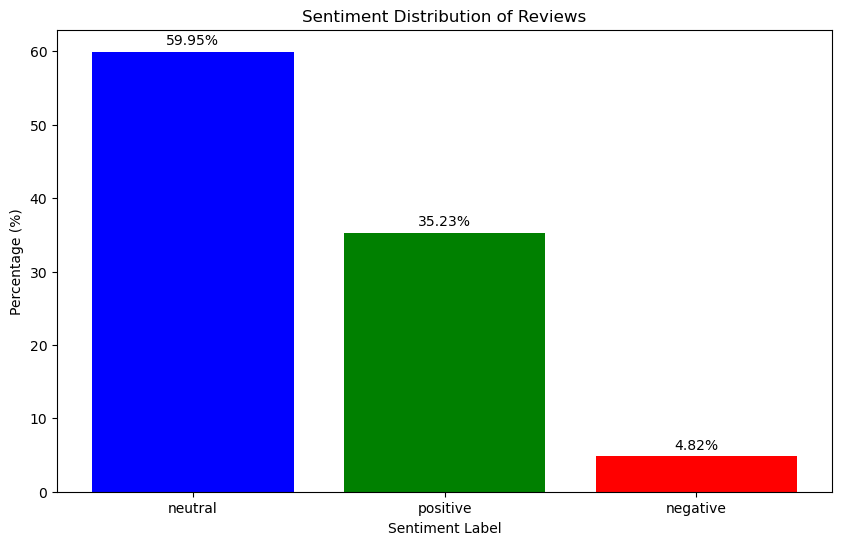

In [ ]:
# Analyze the sentiment distribution
sentiment_distribution = top_lang_data['sentiment_label'].value_counts(normalize=True) * 100

# Plot the sentiment distribution
plt.figure(figsize=(10, 6))
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color=['blue', 'green', 'red'])
for i, value in enumerate(sentiment_distribution.values):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center')
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment Label')
plt.ylabel('Percentage (%)')
plt.show()

### **Question B.3**

Does the sentiment analysis align with whether the application is recommended or not? Explain any insights from this comparison.


To perform the analysis requested, I chose to use a contingency table along with the Chi-square test and Cramer's V. This approach allows for a clear exploration of the relationship between sentiment and recommendations, helping to determine if the association is statistically significant and to measure the strength of that association. The use of a contingency table provides a structured view of the data, making it easier to identify patterns and trends that can inform decisions.

Contingency Table:
recommended            0        1
sentiment_label                  
negative          464427   292772
neutral          1416225  8000703
positive          281623  5252137

Chi-square value: 1807209.524087003
P-value: 0.0
Cramer's V: 0.3391918191818762


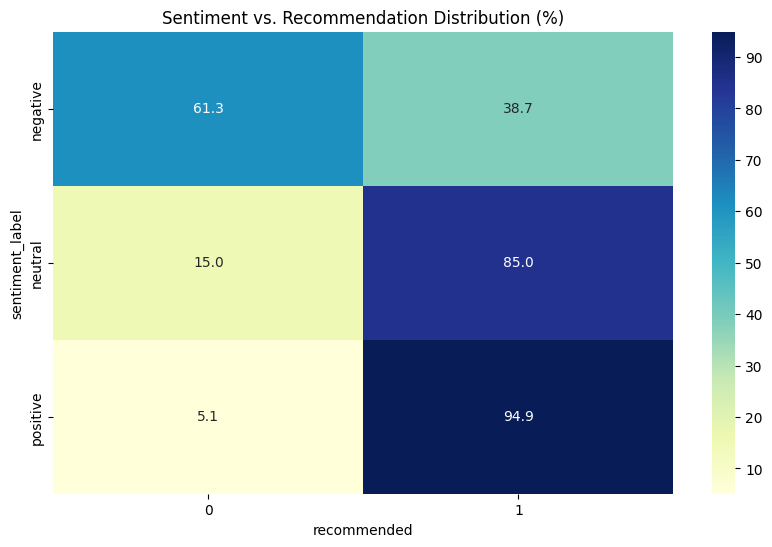

In [ ]:
# Uses the analyze_sentiment_correlation function to analyze the correlation between sentiment and recommendation, define in the functions.py file
results = f.analyze_sentiment_correlation(top_lang_data, sentiment_col='sentiment_label', recommended_col='recommended')
print("Contingency Table:")
print(results['contingency_table'])
print("\nChi-square value:", results['chi_square'])
print("P-value:", results['p_value'])
print("Cramer's V:", results['cramers_v'])

To interpret the contingency table and its associated statistics, we first examine the relationship between two categorical variables: sentiment_label (negative, neutral, positive) and recommended (0, 1). The table presents the frequency of observations for each combination of these variables. For negative sentiment, there are 464,427 instances of not being recommended (0) and 292,772 instances of being recommended (1). Neutral sentiment shows 1,416,225 not recommended and 8,000,703 recommended. Positive sentiment has 281,623 not recommended and 5,252,137 recommended.

Next, we consider the results of the Chi-square test. The Chi-square value of 1,807,209.52 indicates a significant deviation between the observed and expected frequencies, suggesting a strong association between the two variables. The p-value of 0.0 provides further evidence against the null hypothesis, confirming that there is a statistically significant relationship between sentiment_label and the recommendation status.

Finally, we look at Cramer's V, which is calculated at 0.339. This statistic measures the strength of the association between the two variables, with values ranging from 0 to 1. A value of 0.339 indicates a moderate association.

In conclusion, the analysis reveals a statistically significant relationship between sentiment and the likelihood of receiving a recommendation. Specifically, positive sentiments are more likely to lead to recommendations, while negative sentiments are less likely to do so. The strength of this association is moderate, as indicated by Cramer's V.

### **Question B.4**

Is there a correlation between the sentiment of a review and the number of helpfulness votes it receives? Provide an analysis of the results and discuss potential trends.

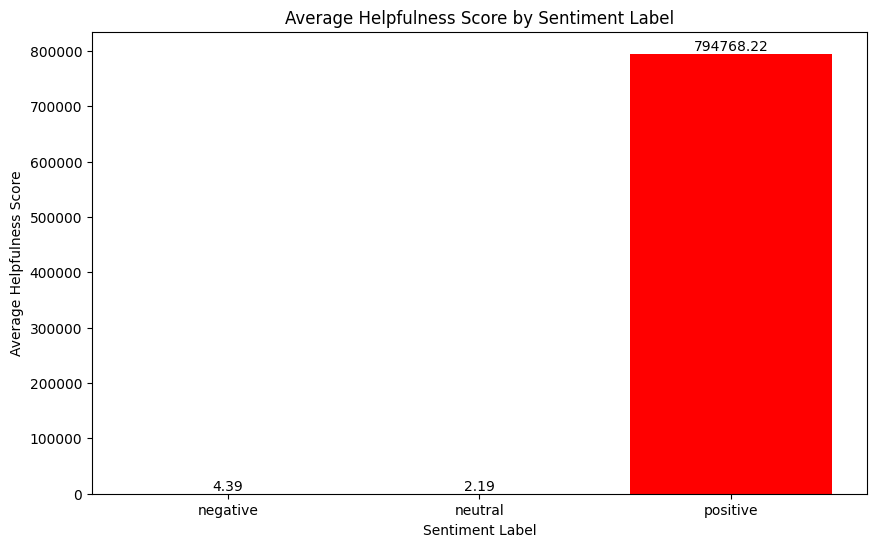

Correlation between sentiment score and helpfulness votes for each sentiment label:
Negative: 0.01781
Neutral: 0.00470
Positive: 0.00010


In [ ]:
# Group by sentiment label and calculate the mean helpfulness score
sentiment_helpfulness = top_lang_data.groupby('sentiment_label')['votes_helpful'].mean()

# Plot the average helpfulness score for each sentiment label
plt.figure(figsize=(10, 6))
bars = plt.bar(sentiment_helpfulness.index, sentiment_helpfulness.values, color=['blue', 'green', 'red'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}', ha='center', va='bottom')
plt.title('Average Helpfulness Score by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Average Helpfulness Score')
plt.show()

# Calculate the correlation between sentiment and helpfulness votes for each sentiment label
correlation_results = {}
for label in sentiment_helpfulness.index:
    subset = top_lang_data[top_lang_data['sentiment_label'] == label]
    correlation = subset['sentiment_score'].corr(subset['votes_helpful'])
    correlation_results[label] = correlation

# Print the correlation results
print("Correlation between sentiment score and helpfulness votes for each sentiment label:")
for label, correlation in correlation_results.items():
    print(f"{label.capitalize()}: {correlation:.5f}")

From the results, it’s clear that reviews with positive sentiment have an overwhelmingly higher average helpfulness score (794,768.22) compared to both negative (4.39) and neutral (2.19) sentiments. This indicates that users generally find positive reviews to be far more helpful than neutral or negative ones.

Additionally, the text below the chart provides correlation values between sentiment score and helpfulness votes for each sentiment label:

- Negative: 0.01781
- Neutral: 0.00470
- Positive: 0.00010

These low correlation values suggest that, within each sentiment category, there is minimal association between the sentiment score and the number of helpfulness votes. This means that whether a review is more strongly positive or negative doesn’t significantly influence its helpfulness score—rather, it seems that the sentiment category (positive, negative, or neutral) itself is more influential in determining helpfulness, with positive reviews generally perceived as more helpful.

In summary, positive reviews receive far more helpfulness votes, while variations in sentiment strength within each category have little impact on helpfulness. This might reflect a general preference among users for positive feedback when assessing the usefulness of reviews.

## **Algorithmic Question (AQ)**
You are given two positive integers, $n$ (where $1\le n \le 10^9$) and k (where $q \le k \le 100$). Your task is to express $n$ as the sum of $k$ positive integers, all having the same parity (i.e., all have the same remainder when divided by 2, meaning they are either all even or all odd).
In other words, find $a_1, a_2, ..., a_k$ each $a_i \gt 0, n = a_1 + a_2 + ... + a_k$, and all $a_i$ simultaneously are either even or odd.
If it's impossible to represent $n$ in this way, report that no such representation exists.

**Input**

In the first input line, you will receive a number t (where $1 \le t \le 100$), representing the number of test cases. The following $t$ lines will contain two values, $n$ and $k$, corresponding to each test case.

**Output**

For each test case, if it is possible to represent $n$ as the sum of $k$ positive integers, all of the same parity (either all even or all odd), print "YES" and provide the corresponding values of $a_i$ in the next line. If there are multiple valid solutions, you can print any of them. If such a representation is not possible for a given test case, print "NO".


### **Question AQ.1**
Implement a Python program to solve the problem above.


The implemented function works as follows:

#### Case 1: Even n and k ≤ n/2
If k is less than or equal to half of n, n can be represented as a sum of 2 repeated n/2 times.
To create k numbers, use the first k-1 numbers as 2, and the last number as the remaining sum.
This always works because summing even numbers (whether an even or odd number of times) always produces an even result.

#### Case 2: Even n and k > n/2
When k exceeds half of n, we cannot use 2 as the base number because 2 * k would exceed n.
This constraint forces us to use 1 as our base number.

If k is odd, it's impossible to represent n as a sum.
An odd number of 1s cannot produce the even value n.

If k is even, n is represented by using 1 for k-1 times.
The last (k-th) number becomes n-(k-1), which will always be odd.

#### Case 3: Odd n and even k
It's impossible to obtain n with a even sum of even or odd numbers.

#### Case 4: Odd n and odd k
n can be represented as a sum of 1 repeated n times.
To create k numbers, use the first k-1 numbers as 1, and the last number as the remaining sum.
The k-th term will be n-(k-1), which will always be odd.

In [ ]:
def find_numbers(n, k):
    """
    Function to find k odd or even numbers that sum up to n based on the given conditions.

    Parameters:
    n (int): The desired sum value.
    k (int): The number of elements to find.
    
    Returns:
    tuple: A tuple containing a boolean value indicating if the numbers were found and the list of numbers (if found).

    """

    if n <= 0 or k <= 0 or k > n:
        return False, np.array([])
    
    if k == 1:
        return True, np.array([n])
    if (n % 2) == 0:
        mid = n // 2
        # Case 1
        if (k <= mid):
            result = np.full(k, 2)
            result[-1] = 2 * (mid - k + 1)
            return True, result
        # Case 2
        else:
            if (k % 2) == 0:
                result = np.full(k, 1)
                result[-1] = n - k + 1
                return True, result
            else:
                return False, np.array([])
        
    if (n % 2) == 1:
        # Case 3
        if (k % 2) == 0:
            return False, np.array([])
        # Case 4
        else:
            result = np.full(k, 1)
            result[-1] = n - k + 1
            return True, result
       
def check_numbers(n, k):
    """ 
    Check if the numbers were found and print the result 
    
    Parameters:
        n (int): The desired sum value.
        k (int): The number of elements to find.
    
    Returns:
        None
        
    """
    check, sum_list = find_numbers(n, k)
    if check:
        print("YES")
        print(*sum_list)
    else:
        print("NO")


# Read the number of test cases and process each test case
t = int(input())

for _ in range(t):
    n, k = map(int, input().split())
    check_numbers(n, k)


### **Question AQ.2** 
Please provide an analysis of your code's time complexity using Big O notation.

The temporal complexity analysis of this code can be broken down into two parts:

1. All initial checks, conditional statements and void/single array creations have a constant time complexity of $O(1)$, as they involve simple comparisons and arithmetic operations.

2. The main operation that impacts the overall complexity is np.full(), which creates an array of size $k$. This operation has a linear time complexity of $O(k)$ since it needs to allocate and initialize $k$ elements, making its execution time directly proportional to the size of $k$.

Therefore, considering that the dominant operation in the code is the array creation with np.full(), the overall time complexity of the algorithm is $O(k)$. This linear complexity reflects that the execution time grows proportionally with the input parameter $k$.

### **Question AQ.3** 
Ask an LLM tool (such as ChatGPT, Claude AI, Gemini, Perplexity, etc.) to evaluate the time complexity of your code using Big O notation. Is the assessment accurate? If it differs from your previous analysis, which would be correct? Please explain your reasoning.

I reviewed the find_numbers function, and here's the ChatGPT's analysis of its time complexity and structure:

First, the function checks for invalid inputs, such as when $n$ or $k$ are non-positive or when $k$ is greater than  $n$. This part runs in constant time, $O(1)$.
Next, if  $n$ is 1, the function directly returns a NumPy array containing just $n$, which is also $O(1)$.
For even values of $n$:

In Case 1, if  $n$ is less than or equal to half of nn, it creates an array of size $k$ filled with $2$. This operation, np.full(k,2), runs in $O(k)$, and adjusting the last element takes $O(1)$. So, the total time for this case is $O(k)$.

In Case 2, if  $n$ is greater than half of $n$, it checks if $k$ is even or odd. Depending on the condition, it creates an array filled with $1$ , leading to the same complexity of $O(k)$.

For odd values of $n$: 

In Case 3, if $n$ is even, the function quickly returns an empty array, which is $O(1)$.

In Case 4, if $n$ is odd, it creates another array of size $n$ filled with 11s and adjusts the last element, resulting again in $O(k)$.

Overall, the function's time complexity is $O(k)$, which comes from creating the result arrays in the various cases. The space complexity is also $O(k)$ due to the arrays created.

This assessment is accurate and don't differ from my previous analysis.